# Acquisite Defective Data

## Faulty data information
- Architecture Model : Gen3.5K Steering System
- Project : CANoo LV (SFA, RWA)
- Repository : PTC Integrity CM module
- Period : 19.03 ~ 20.06
- Released software
- Data
    - Released software data (ptc checkpoint)
    - Software metric
        - loc, cyclomatic complexity, parameter count, function count
    - Halsted metric
        - loc, program length, volumume, operator, 
    - Domain metric
        - SAD 기준 up/downstream trace data (SR <-> SAD <-> SUD/SIT)
        - Experience data of changer
        - Software category (new, reuse, reused with modification)

### Load & merge data

In [366]:
# load all data from local repository

df = pd.DataFrame()
df_sfa = pd.DataFrame()
df_rwa = pd.DataFrame()

df_sfa_init = pd.read_excel("./trainData/SFA_initData.xlsx", sheet_name="dataset")
df_sfa = pd.read_excel("./trainData/SFA_Faulty_Dataset.xlsx", sheet_name="dataset")
df_rwa_init = pd.read_excel("./trainData/RWA_initData.xlsx", sheet_name="dataset")
df_rwa = pd.read_excel("./trainData/RWA_Faulty_Dataset.xlsx", sheet_name="dataset")
df_exp = pd.read_excel("./trainData/baseData.xlsx", sheet_name="name")
df_trace = pd.read_excel("./trainData/SADS_Trace_Report.xlsx")

### EDA (탐색적 데이터 분석)
- 데이터 분석을 통한 이해
- 데이터 타입 (연속형 / 범주형 / 이산형)
- 데이터 위치와 변이, 결측치 확인 및 처리
    - describe(), info(), isnull()
    - lib : missingno (msno.matrix(), msno.bar())
    - 결측치 데이터 처리
- 데이터 산점도, 히스토그램, 상관관계 분석

#### Merge data 1 (append)
- Sfa dataframe : all released software
- Rwa dataframe : all released software


In [367]:
# drop expMonths column
df_sfa = df_sfa.drop(columns=['expMonths'])
df_sfa_init = df_sfa_init.drop(columns=['expMonths'])
df_rwa = df_rwa.drop(columns=['expMonths'])
df_rwa_init = df_rwa_init.drop(columns=['expMonths'])

df_sfa = df_sfa.append([df_sfa_init,df_sfa]).reset_index(drop=True)
df_rwa = df_rwa.append([df_rwa_init,df_rwa]).reset_index(drop=True)

df = df.append([df_sfa_init,df_sfa,df_rwa_init,df_rwa]).reset_index(drop=True)

# remove duplicate instance
df_sfa = df_sfa.drop_duplicates().reset_index(drop=True)
df_rwa = df_rwa.drop_duplicates().reset_index(drop=True)
df = df.drop_duplicates().reset_index(drop=True)
df.shape
df.to_excel('init_dataframe.xlsx', engine='xlsxwriter')

In [369]:
# remove unnecessary instance (unidentified SWC)

df_sfa.drop(df_sfa.loc[pd.isna(df_sfa['swcName'])].index, inplace=True)

In [370]:
print(df_sfa['isDefective'].value_counts())
print(df_rwa['isDefective'].value_counts())

N    253
Y     56
Name: isDefective, dtype: int64
N    224
Y     46
Name: isDefective, dtype: int64


#### 클래스 비율 (Sfa, Rwa)

In [372]:
df_sfa['sysName'] = 'Sfa'
df_rwa['sysName'] = 'Rwa'

df = pd.concat([df_sfa, df_rwa], axis=0).reset_index(drop=True)

In [373]:
df['defectStatus'] = np.nan
df['defectStatus'] =(df['isDefective']=='Y').astype(int)

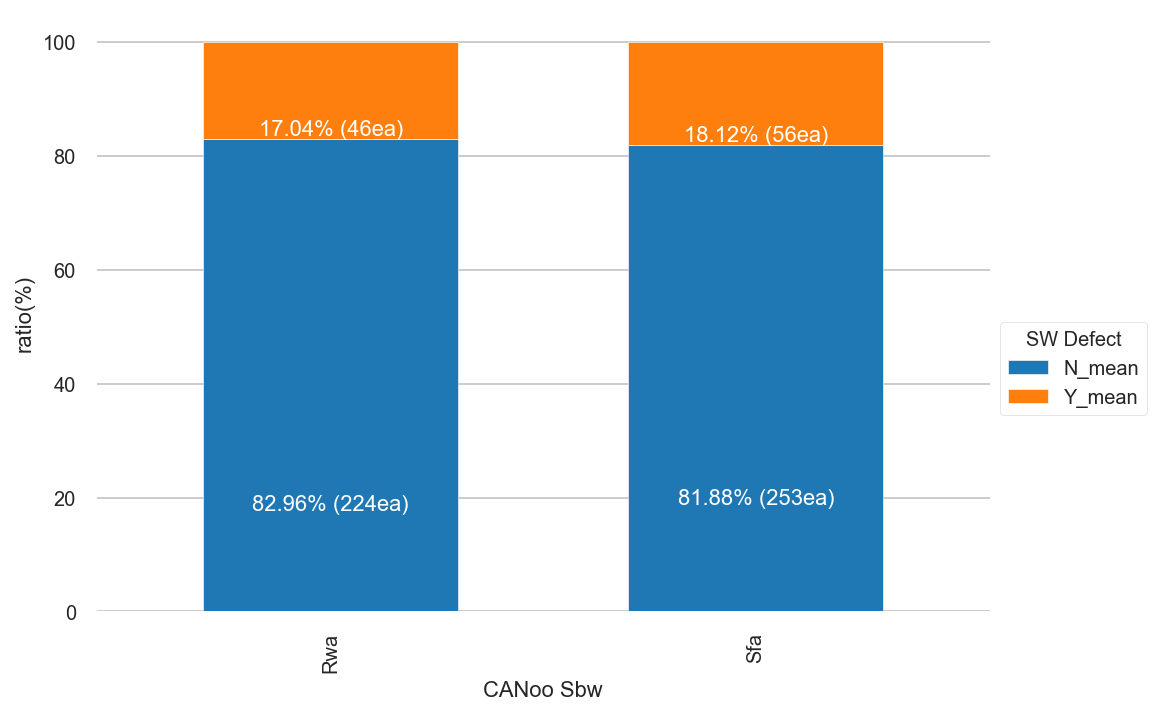

In [374]:
# f, axes = plt.subplots(1, 1, sharex=True, sharey=True)
# f.set_size_inches((16, 4)) 

#df_defect_arr.set_index('sysName').T.plot(kind='bar', stacked=True)

ct_df = df.pivot_table("defectStatus", "sysName", "isDefective", aggfunc='count')
ct_df['sum'] = ct_df['N'] + ct_df['Y']
ct_df['N_mean'] = round(ct_df['N'] / ct_df['sum'] * 100, 2)
ct_df['Y_mean'] = round(ct_df['Y'] / ct_df['sum'] * 100, 2)
ct_df_pivot = ct_df[["N_mean", "Y_mean"]]
ct_df_num_pivot = ct_df[["N", "Y"]]

ct_df_pivot.plot.bar(stacked=True, width=0.6)
plt.legend(title='SW Defect', loc='best', bbox_to_anchor=(1, 0.5))
plt.xlabel('CANoo Sbw')
plt.ylabel('ratio(%)')
plt.grid(which='major', axis='y')


for i, v in enumerate(ct_df_pivot.loc[:].T):
    for j, x in enumerate(ct_df_pivot.loc[:]):
        plt.text(i, 100-ct_df_pivot.loc[v, x], "{}% ({}ea)".format(ct_df_pivot.loc[v, x],ct_df_num_pivot.loc[v, x.split('_')[0]]), 
                 fontsize=11, horizontalalignment='center', verticalalignment='bottom', color='#ffffff')

plt.show()

#### 데이터 전처리 & Merge data 2 (merge)
- 데이터 전처리
    - SWC version 으로부터 revision frequency 추출
    - SWC name 에서 only SWC name 만 추출
- 데이터 통합
    - faulty data <- experience data (on engineer name)
    - faulty data <- trace data (on software component)

In [376]:
df_1 = df.copy()

In [377]:
df_1.shape

(579, 29)

In [379]:
# faulty data에서 swcName 중 only software component split 하여 moduleName 컬럼 추가
# faulty data에서 creationInfo 중 changer split 하여 changer 컬럼 추가

df_1["moduleName"] = pd.DataFrame([name[-1] for name in df_1['swcName'].str.split('/')])
df_1['creationInfo'] = df_1.fillna('함설희 (seolhee.ham) on Mar 8, 2019 9:59:56 AM KST')['creationInfo']
df_1["changer"] = pd.DataFrame([name[0].strip() for name in df_1['creationInfo'].str.split('(')])
df_exp.rename(columns={'name':'changer'}, inplace=True)
df_trace.rename(columns={'Unnamed: 0':'moduleName'}, inplace=True)

In [380]:
# fauly data <- experience data
# fauly data <- trace data

df_2 = pd.merge(df_1, df_exp, on='changer', how='left')
df_3 = pd.merge(df_2, df_trace, on='moduleName', how='left')

In [381]:
df_3.to_excel('df_3.xlsx', engine='xlsxwriter')

In [383]:
df_3.columns

Index(['Order', 'swcName', 'swcVer', 'progLength', 'vocaCnt', 'volume',
       'difficultyLv', 'progLv', 'effortToImpl', 'timeToImpl', 'nloc',
       'minParaCnt', 'maxParaCnt', 'totalParaCnt', 'funCnt', 'minCyclo',
       'maxCyclo', 'avgCyclo', 'impactBoundary', 'creationInfo', 'nrev',
       'memberRev', 'pPORT', 'rPORT', 'activityId', 'crId', 'isDefective',
       'sysName', 'defectStatus', 'moduleName', 'changer', 'expMonths',
       'start date to join ', 'ID', 'Upstream Trace Count',
       'Downstream Trace Count', 'Implements', 'Decomposes To', 'Verified By',
       'SW Category'],
      dtype='object')

In [384]:
df_3.isnull().sum()

Order                       0
swcName                     0
swcVer                      0
progLength                  0
vocaCnt                     0
volume                      0
difficultyLv                0
progLv                      0
effortToImpl                0
timeToImpl                  0
nloc                        0
minParaCnt                  0
maxParaCnt                  0
totalParaCnt                0
funCnt                      0
minCyclo                    0
maxCyclo                    0
avgCyclo                    0
impactBoundary             20
creationInfo                0
nrev                        0
memberRev                   0
pPORT                      79
rPORT                      79
activityId                  0
crId                        0
isDefective                 0
sysName                     0
defectStatus                0
moduleName                  0
changer                     0
expMonths                  49
start date to join        141
ID        

#### Descriptive statistics

In [385]:
sfa_df_3 = df_3[df_3['sysName']=='Sfa']
rwa_df_3 = df_3[df_3['sysName']=='Rwa']

In [386]:
round(sfa_df_3.describe().T, 2).to_excel('sfa_describe.xlsx', engine='xlsxwriter')
round(rwa_df_3.describe().T, 2).to_excel('rwa_describe.xlsx', engine='xlsxwriter')

In [387]:
df_4 = df_3.drop(columns=['Order', 'swcName', 'swcVer', 'impactBoundary', 'creationInfo', 'activityId', 'crId', 
                          'sysName', 'defectStatus', 'start date to join ', 'ID', 'Upstream Trace Count', 'Downstream Trace Count', 
                          'Decomposes To', 'SW Category'])

#### Pandas data profiling

In [388]:
from pandas_profiling import ProfileReport

In [389]:
sfa_profile = ProfileReport(sfa_df_4, title="Pandas Profiling Report")
rwa_profile = ProfileReport(rwa_df_4, title="Pandas Profiling Report")

In [208]:
sfa_profile.to_file('sfa_profile.html')
rwa_profile.to_file('rwa_profile.html')

In [390]:
# train_1
# column drop, ordering
# changed to train_1

df_4 = df_3.drop(columns=['Order', 'swcName', 'swcVer', 'impactBoundary', 'creationInfo', 'activityId', 'crId', 
                          'sysName', 'defectStatus', 'start date to join ', 'ID', 'Upstream Trace Count', 
                          'Decomposes To', 'SW Category'])

In [391]:
# column name change

df_4.rename(columns={'Downstream Trace Count':'downTrace', 
                      'Implements':'nreq',
                      'Verified By':'ntest'}, inplace=True)

In [392]:
# -1 : 미 결함, 1 : 결함

df_4['isDefective'] = df_4['isDefective'].replace({'N':-1, 'Y':1})
df_4['isDefective'].value_counts()*100/len(df_4)

-1    82.38342
 1    17.61658
Name: isDefective, dtype: float64

#### Missing data

In [393]:
df_5 = df_4.copy()

In [394]:
df_5.shape

(579, 26)

In [395]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 578
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   progLength    579 non-null    float64
 1   vocaCnt       579 non-null    float64
 2   volume        579 non-null    float64
 3   difficultyLv  579 non-null    float64
 4   progLv        579 non-null    float64
 5   effortToImpl  579 non-null    float64
 6   timeToImpl    579 non-null    float64
 7   nloc          579 non-null    float64
 8   minParaCnt    579 non-null    float64
 9   maxParaCnt    579 non-null    float64
 10  totalParaCnt  579 non-null    float64
 11  funCnt        579 non-null    float64
 12  minCyclo      579 non-null    float64
 13  maxCyclo      579 non-null    float64
 14  avgCyclo      579 non-null    float64
 15  nrev          579 non-null    float64
 16  memberRev     579 non-null    float64
 17  pPORT         500 non-null    float64
 18  rPORT         500 non-null    

In [268]:
# 데이터의 확인을 위해 액셀로 파일로 만듬

df_5.to_excel('df5.xlsx', engine='xlsxwriter')

- Missing data
    - pPort, rPort
    - expMonths
    - Implements, Verified By

In [396]:
df_5.loc[df_5['nreq'].isnull()]

,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,maxParaCnt,...,memberRev,pPORT,rPORT,isDefective,moduleName,changer,expMonths,downTrace,nreq,ntest
37,2218.0,188.0,16756.078073,59.541916,4.726360,997688.995923,55427.166440,409.0,1.0,8.0,...,2.0,4.0,5.0,-1,TarTorsBarTqGenr,홍승규,103.245902,NaN,NaN,NaN
43,2559.0,359.0,21720.382647,38.584071,14.589869,838060.781761,46558.932320,233.0,0.0,1.0,...,1.0,NaN,NaN,-1,DmaMc,함설희,6.000000,NaN,NaN,NaN
44,205.0,46.0,1132.330201,16.411765,4.203998,18583.536828,1032.418713,37.0,1.0,1.0,...,5.0,NaN,NaN,-1,DQTransform,조소영,65.967213,NaN,NaN,NaN
49,1919.0,509.0,17254.730423,18.864286,48.487238,325498.164615,18083.231368,122.0,1.0,1.0,...,3.0,NaN,NaN,-1,PwmMc,문준석,53.836066,NaN,NaN,NaN
50,301.0,94.0,1972.931244,16.889610,6.916282,33322.040043,1851.224447,46.0,0.0,2.0,...,1.0,NaN,NaN,-1,SpiMc,함설희,6.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,997.0,143.0,7138.391723,26.834646,9.913081,191556.212529,10642.011807,222.0,1.0,1.0,...,6.0,3.0,7.0,-1,OverHeatProtn,신창우,77.934426,NaN,NaN,NaN
570,920.0,135.0,6510.670349,24.347458,10.982936,158518.270453,8806.570581,168.0,1.0,1.0,...,12.0,120.0,18.0,-1,RunningRstDiagc,김대성,130.262295,NaN,NaN,NaN
573,328.0,61.0,1945.281847,23.466667,3.532480,45649.280670,2536.071148,73.0,1.0,1.0,...,2.0,1.0,2.0,-1,StkOverDiagc,sohee.park,NaN,NaN,NaN,NaN
574,72.0,22.0,321.079077,15.000000,1.427018,4816.186148,267.565897,2030.0,1.0,1.0,...,26.0,NaN,NaN,-1,SysLib,sohee.park,NaN,NaN,NaN,NaN


In [397]:
df_5.loc[df_5['expMonths'].isnull()]

,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,maxParaCnt,...,memberRev,pPORT,rPORT,isDefective,moduleName,changer,expMonths,downTrace,nreq,ntest
58,313.0,50.0,1766.526987,18.789474,5.003697,33192.112342,1844.006241,313.0,1.0,1.0,...,21.0,123.0,13.0,-1,BattUDiagc,허진욱,NaN,2.0,14.0,0.0
77,1017.0,103.0,6800.171036,36.505747,5.102668,248245.324262,13791.406903,191.0,1.0,2.0,...,2.0,1.0,11.0,-1,MotPhaOpenDiagc,허진욱,NaN,2.0,2.0,0.0
84,29.0,15.0,113.299827,4.000000,7.081239,453.199309,25.177739,9.0,1.0,1.0,...,1.0,121.0,7.0,-1,PartnWdgIf,sohee.park,NaN,0.0,1.0,0.0
91,213.0,57.0,1242.405573,14.325581,6.053951,17798.182162,988.787898,48.0,1.0,1.0,...,5.0,120.0,15.0,-1,SigCorrlnDiagc,sohee.park,NaN,2.0,1.0,0.0
100,166.0,40.0,883.440064,12.896552,5.311655,11393.330477,632.962804,45.0,1.0,1.0,...,4.0,122.0,8.0,-1,VehSpd,허진욱,NaN,2.0,4.0,0.0
102,986.0,232.0,7747.969261,23.962264,13.493735,185658.886070,10314.382559,137.0,1.0,1.0,...,5.0,26.0,19.0,-1,ActrMot,김영범,NaN,74.0,1.0,72.0
128,986.0,232.0,7747.969261,23.962264,13.493735,185658.886070,10314.382559,137.0,1.0,1.0,...,5.0,26.0,19.0,-1,ActrMot,김영범,NaN,74.0,1.0,72.0
202,1397.0,146.0,10044.184909,42.046875,5.681294,422326.587335,23462.588185,241.0,1.0,8.0,...,5.0,1.0,3.0,-1,HptcCtrl,김정열,NaN,1.0,7.0,0.0
222,72.0,22.0,321.079077,15.000000,1.427018,4816.186148,267.565897,2247.0,1.0,1.0,...,27.0,NaN,NaN,-1,SysLib,sohee.park,NaN,NaN,NaN,NaN
259,878.0,152.0,6363.680357,32.196970,6.138728,204891.223609,11382.845756,120.0,1.0,1.0,...,19.0,NaN,NaN,-1,MotISnsr,seonggwon.jeong,NaN,0.0,2.0,0.0


In [399]:
# 경력 결측치 경력 컬럼에서 최대값으로 채우기
df_5['expMonths'].fillna(max(df_5['expMonths']), inplace=True)

In [400]:
# changer 의 experience month 결측치
# sbw 초기 carry over 된 컴포넌트로서 실제 sbw 담당자는 아니고, 과거 타 프로젝트에서 SWC 를 마지막으로 변경했던 사람
# 데이터 수 자체가 너무 적어 지우는 것보다는 mean 값으로 채우기 ?

# 데이터 삭제

df_6 = df_5.dropna(subset=['pPORT', 'rPORT', 'nreq', 'ntest']).reset_index(drop=True)

In [401]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   progLength    461 non-null    float64
 1   vocaCnt       461 non-null    float64
 2   volume        461 non-null    float64
 3   difficultyLv  461 non-null    float64
 4   progLv        461 non-null    float64
 5   effortToImpl  461 non-null    float64
 6   timeToImpl    461 non-null    float64
 7   nloc          461 non-null    float64
 8   minParaCnt    461 non-null    float64
 9   maxParaCnt    461 non-null    float64
 10  totalParaCnt  461 non-null    float64
 11  funCnt        461 non-null    float64
 12  minCyclo      461 non-null    float64
 13  maxCyclo      461 non-null    float64
 14  avgCyclo      461 non-null    float64
 15  nrev          461 non-null    float64
 16  memberRev     461 non-null    float64
 17  pPORT         461 non-null    float64
 18  rPORT         461 non-null    

In [402]:
# 경력과 loc 간의 비율을 위한 컬럼 추가

# train_2["rating"] = train_2["nloc"] / train_2["expMonths"]

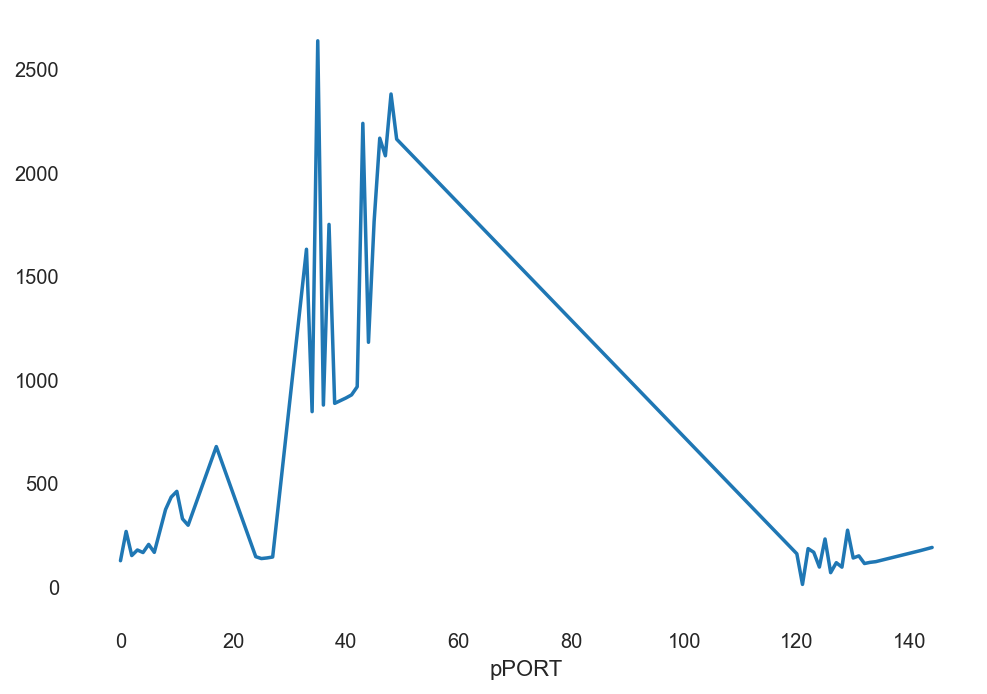

In [403]:
df_6.groupby('pPORT')['nloc'].mean().plot()

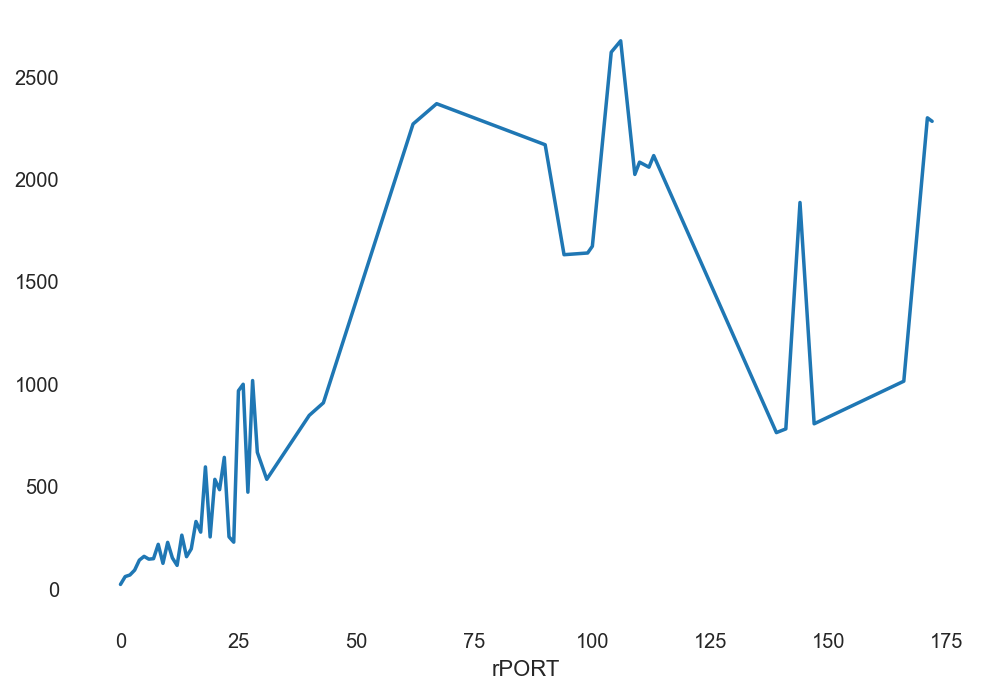

In [404]:
df_6.groupby('rPORT')['nloc'].mean().plot()    

In [405]:
df_6[(df_6['rPORT']>100) & (df_6['nloc']<2000)]

,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,maxParaCnt,...,memberRev,pPORT,rPORT,isDefective,moduleName,changer,expMonths,downTrace,nreq,ntest
0,7.0,7.0,19.651484,2.000000,4.912871,3.930297e+01,2.183498,1920.0,1.0,2.0,...,21.0,37.0,144.0,-1,ApplCom,조영훈,51.081967,1.0,114.0,0.0
70,4655.0,332.0,38985.808553,59.522508,11.003836,2.320533e+06,128918.505721,760.0,1.0,1.0,...,2.0,1.0,139.0,-1,SteerTarTqGenr,홍승규,103.245902,1.0,6.0,0.0
125,4748.0,335.0,39826.306071,60.023885,11.054060,2.390530e+06,132807.201640,778.0,1.0,1.0,...,3.0,1.0,141.0,-1,SteerTarTqGenr,홍승규,103.245902,1.0,6.0,0.0
147,4748.0,335.0,39826.306071,60.023885,11.054060,2.390530e+06,132807.201640,778.0,1.0,1.0,...,3.0,1.0,141.0,-1,SteerTarTqGenr,홍승규,103.245902,1.0,6.0,0.0
187,4925.0,346.0,41540.544021,57.239264,12.678974,2.377750e+06,132097.230987,803.0,1.0,1.0,...,4.0,1.0,147.0,-1,SteerTarTqGenr,이재우,18.032787,1.0,6.0,0.0
210,6255.0,405.0,54179.422002,61.766234,14.201432,3.346459e+06,185914.380259,1011.0,1.0,4.0,...,6.0,1.0,166.0,-1,SteerTarTqGenr,이재우,18.032787,1.0,6.0,0.0
244,7.0,7.0,19.651484,2.000000,4.912871,3.930297e+01,2.183498,1847.0,1.0,2.0,...,21.0,37.0,144.0,-1,ApplCom,조영훈,51.081967,1.0,114.0,0.0


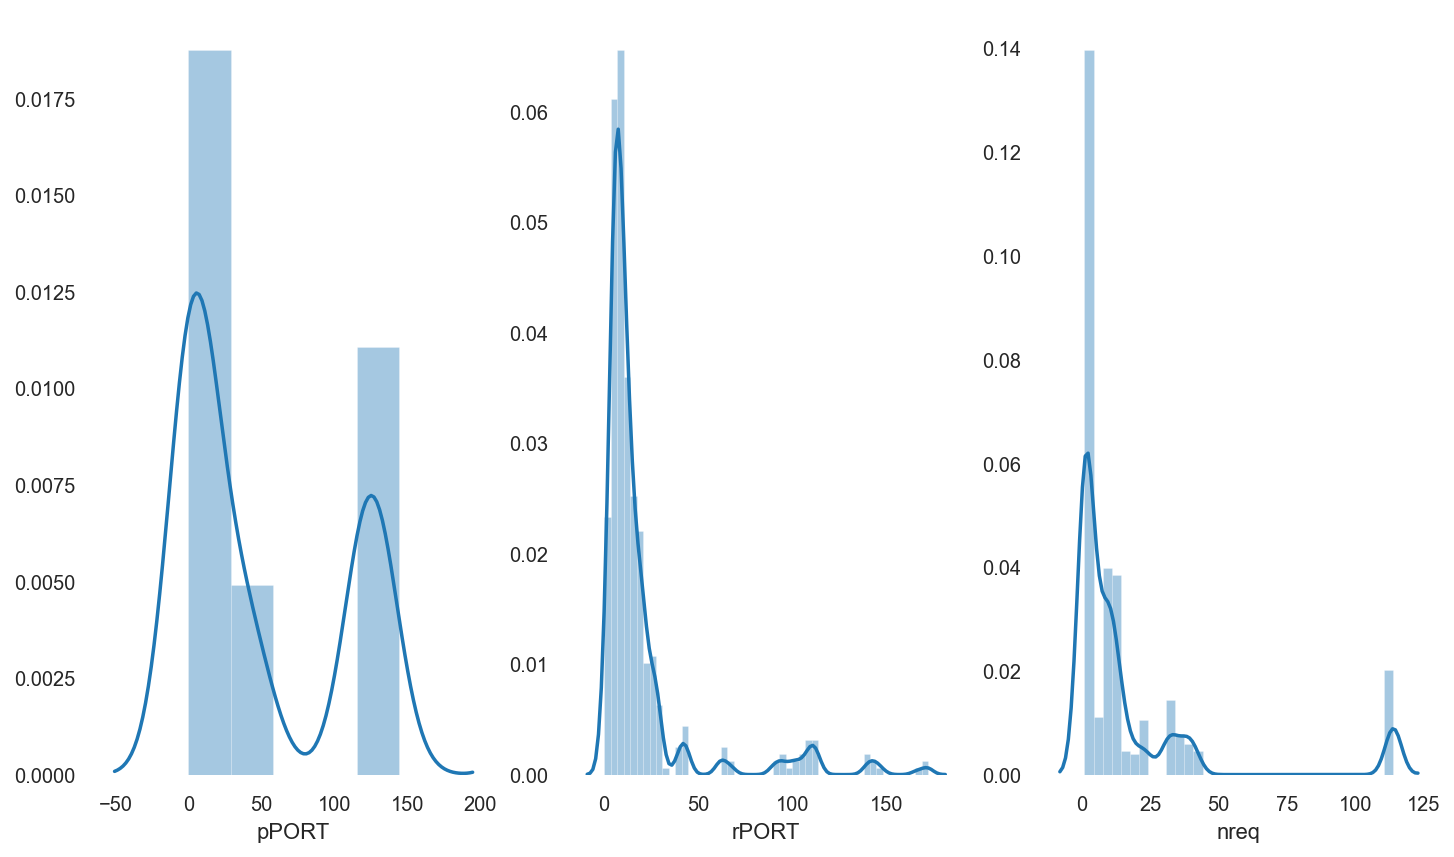

In [406]:
# 결측치 데이터를 어떻게 채울지 분석 필요 (pPOrt, rPort)
# pPORT 결측치 데이터의 경향성이 없어 해당 instance 삭제 ?

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

#fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(12, 7)

sns.distplot(df_6.pPORT, ax=ax1)
sns.distplot(df_6.rPORT, ax=ax2)
sns.distplot(df_6.nreq, ax=ax3)

In [26]:
# NaN 이 포함된 p-port, r-port에 대해 row 삭제 처리 (SW architecture 가 없어 r/p port 확인이 어려운 software component)
# train_1 는 컬럼 정리한 data frame
# train_2 는 NaN 데이터 삭제된 data frame

# train_3 = train_2.dropna(axis=0, how='any').reset_index(drop=True)

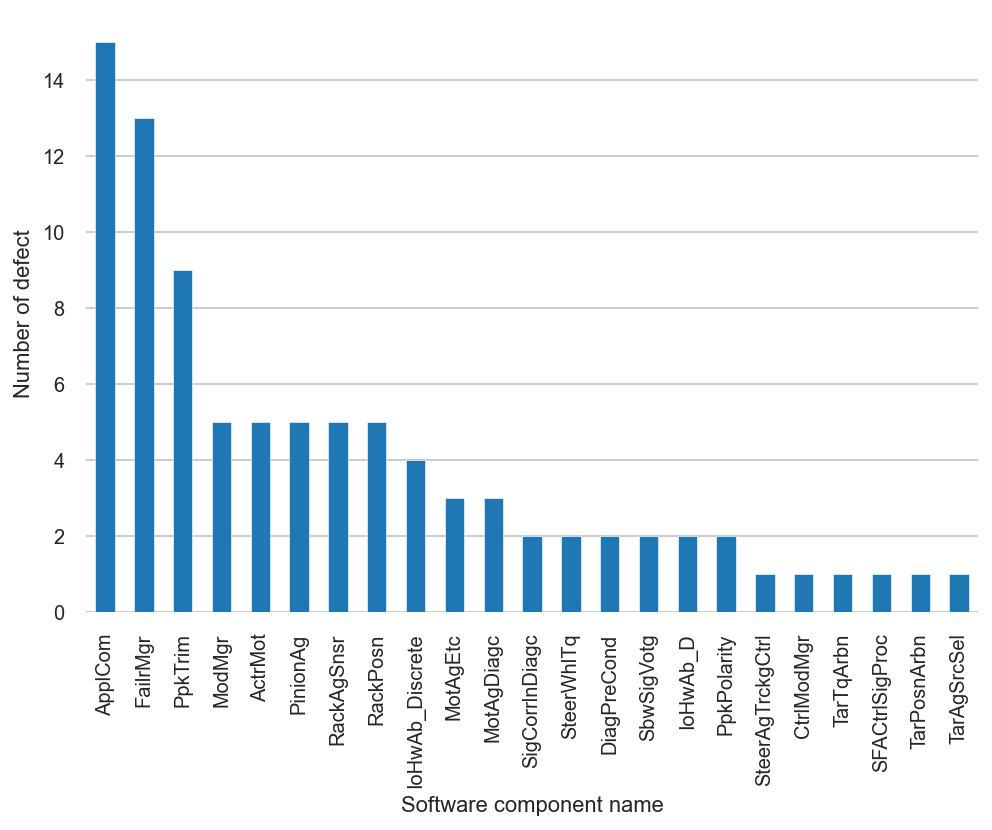

In [407]:
# SWC 별 결함 발생 수

df_6[df_6['isDefective'] == 1]['moduleName'].value_counts().plot.bar()
plt.grid(axis='y')
plt.xlabel('Software component name')
plt.ylabel('Number of defect')
plt.show()

In [408]:
df_4.groupby(['moduleName'])['isDefective'].value_counts()

moduleName      isDefective
ActrMot         -1              8
                 1              5
AnalyticRec     -1              4
ApplCom         -1             16
                 1             15
                               ..
TqTrckgCtrl     -1              3
TunVrntSel      -1              6
VehKinematCtrl  -1              5
VehSpd          -1              8
YawRate         -1              2
Name: isDefective, Length: 117, dtype: int64

#### Reduce data imbalance

In [409]:
# 데이터 불균형 해소를 위해 
# 결함 발생이 한 번이라도 있었던 SWC 에 대해 미 결함 행 제거

cols_1 = ['ApplCom', 'FailrMgr', 'PpkTrim', 'PinionAg', 'RackPosn', 'ActrMot', 'RackAgSnsr', 'ModMgr', 'IoHwAb_Discrete']
cols_2 = ['MotAgDiagc', 'MotAgEtc', 'SteerWhlTq',  'PpkPolarity', 'SigCorrlnDiagc','SbwSigVotg', 'DiagPreCond', 'IoHwAb_D']

for name in cols_1:
    df_6.drop(df_6[(df_6['moduleName'] == name) & (df_6['isDefective'] == -1)].index, inplace=True)

In [410]:
df_6['isDefective'].value_counts()*100/len(df_6)

#df_4["isDefective"].value_counts(normalize=True)*100

-1    76.863753
 1    23.136247
Name: isDefective, dtype: float64

#### 데이터 시각화를 통한 분석 (seaborn)

In [478]:
df_7 = df_6.copy()

In [479]:
df_7.columns

Index(['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv',
       'effortToImpl', 'timeToImpl', 'nloc', 'minParaCnt', 'maxParaCnt',
       'totalParaCnt', 'funCnt', 'minCyclo', 'maxCyclo', 'avgCyclo', 'nrev',
       'memberRev', 'pPORT', 'rPORT', 'isDefective', 'moduleName', 'changer',
       'expMonths', 'downTrace', 'nreq', 'ntest'],
      dtype='object')

In [480]:
df_7_metric = df_7[['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv',
       'effortToImpl', 'timeToImpl', 'nloc', 'minParaCnt', 'maxParaCnt',
       'totalParaCnt', 'funCnt', 'minCyclo', 'maxCyclo', 'avgCyclo', 'isDefective']]

In [481]:
sns.set(style='darkgrid')

In [482]:
df_7.columns
df_7['isDefective'].value_counts()

-1    299
 1     90
Name: isDefective, dtype: int64

In [483]:
#train_3[(train_3['expMonths']<80) & (train_3['nloc']>1200)]
df_7[df_7['moduleName'] =='ApplCom']

,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,maxParaCnt,...,memberRev,pPORT,rPORT,isDefective,moduleName,changer,expMonths,downTrace,nreq,ntest
115,703.0,69.0,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2056.0,1.0,1.0,...,81.0,49.0,112.0,1,ApplCom,박민기,24.000000,1.0,114.0,0.0
127,703.0,69.0,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2056.0,1.0,1.0,...,81.0,49.0,112.0,1,ApplCom,박민기,24.000000,1.0,114.0,0.0
138,703.0,69.0,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2056.0,1.0,1.0,...,81.0,49.0,112.0,1,ApplCom,박민기,24.000000,1.0,114.0,0.0
154,703.0,69.0,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2108.0,1.0,1.0,...,89.0,49.0,113.0,1,ApplCom,박민기,24.000000,1.0,114.0,0.0
160,703.0,69.0,4294.292693,34.241071,3.662663,1.470412e+05,8168.954602,2117.0,1.0,1.0,...,93.0,49.0,113.0,1,ApplCom,박민기,24.000000,1.0,114.0,0.0
167,3905.0,352.0,33034.080471,28.927928,39.475494,9.556075e+05,53089.305501,2361.0,1.0,2.0,...,44.0,49.0,67.0,1,ApplCom,Yadunandan Kasu,12.655738,1.0,114.0,0.0
192,4261.0,369.0,36335.579523,29.178571,42.677998,1.060220e+06,58901.127917,2371.0,1.0,2.0,...,51.0,49.0,67.0,1,ApplCom,Yadunandan Kasu,12.655738,1.0,114.0,0.0
201,4259.0,372.0,36368.277377,28.796034,43.858864,1.047262e+06,58181.230647,2379.0,1.0,5.0,...,59.0,48.0,62.0,1,ApplCom,Yadunandan Kasu,12.655738,1.0,114.0,0.0
356,823.0,74.0,5110.380120,36.762295,3.781360,1.878693e+05,10437.183442,2024.0,1.0,1.0,...,85.0,45.0,109.0,1,ApplCom,박민기,24.000000,1.0,114.0,0.0
368,823.0,74.0,5110.380120,36.762295,3.781360,1.878693e+05,10437.183442,2019.0,1.0,1.0,...,86.0,45.0,109.0,1,ApplCom,박민기,24.000000,1.0,114.0,0.0


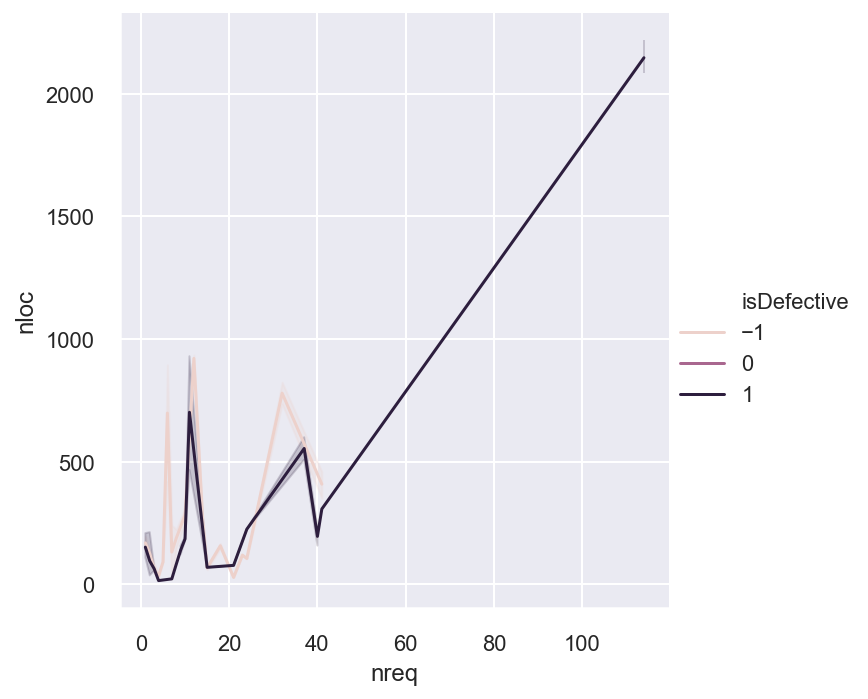

In [467]:
# 경력과 라인수 관계에 결함 발생이 어떻게 되는 지?
# 500 loc 이하에서는 경력과 관계없이 결함 발생이 거의 없음
# 경력이 짧고, LOC 가 길수록 결함 발생 높음 (60개월 미만까지)
# 경력이 60개월 초과 이후에서는, LOC 가 길수록 결함 발생 높음 (60개월 미만까지)

sns.relplot(x='nreq', y='nloc', kind='line', data=df_7, hue='isDefective')

- SW 요구사항과 nLOC 와 관계는 선형적 관계를 보임

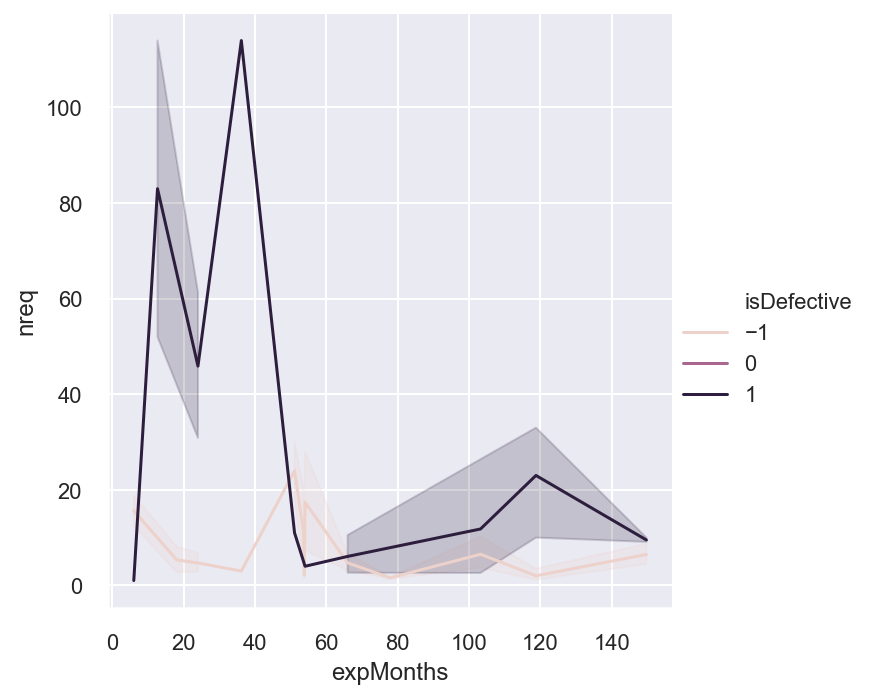

In [466]:
sns.relplot(x='expMonths', y='nreq', kind='line', data=df_7, hue='isDefective')

In [484]:
df_7['isDefective'] = df_7['isDefective'].replace({-1:'N', 1:'Y'})
df_7['isDefective'].value_counts()

N    299
Y     90
Name: isDefective, dtype: int64

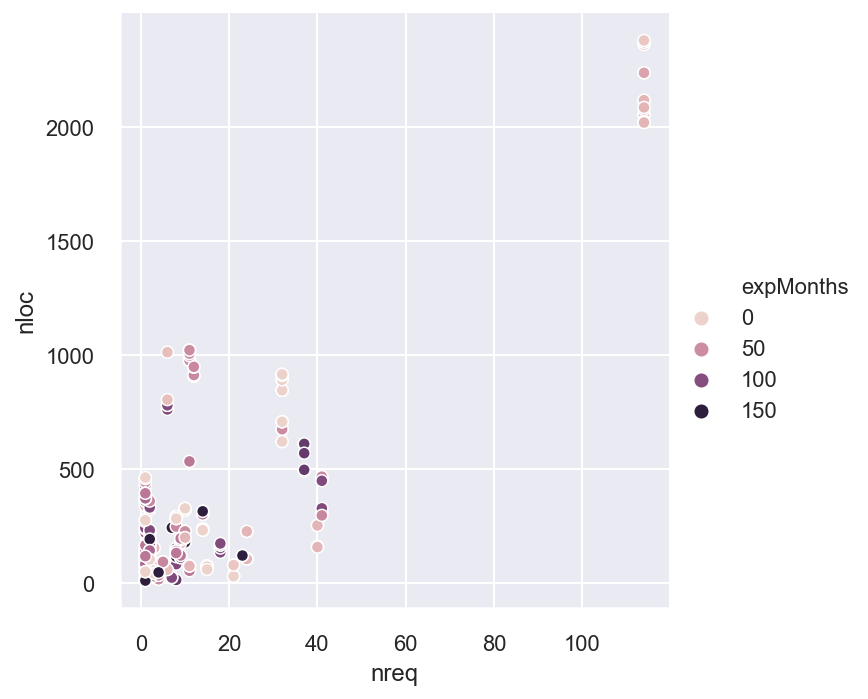

In [419]:
# hue: 색상 입히기 (범주형 hue='isDefective', 연속형 hue='expMonths')

sns.relplot(x='nreq', y='nloc', data=df_7, hue='expMonths')

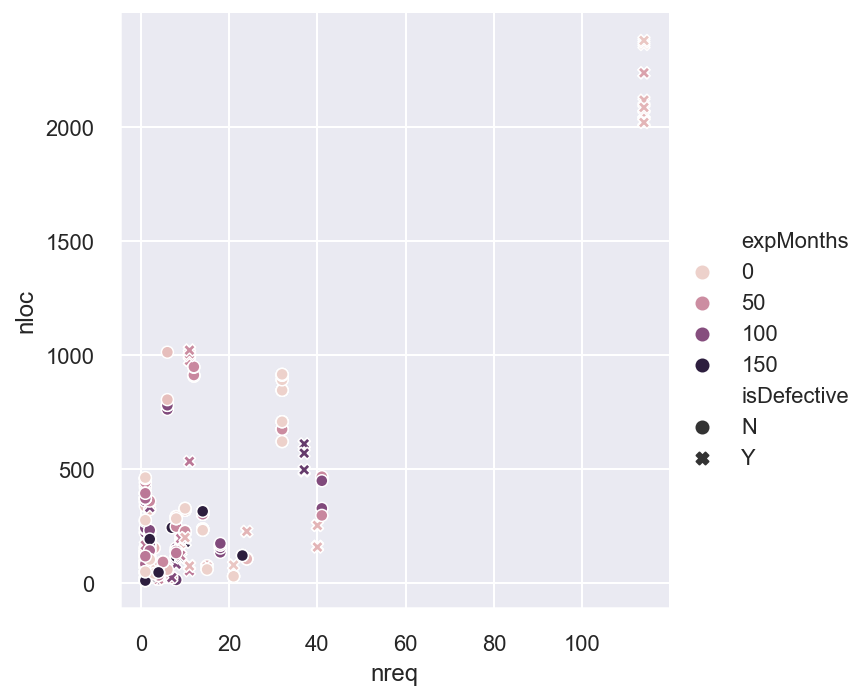

In [420]:
# marker style & hue

sns.relplot(x='nreq', y='nloc', data=df_7, style='isDefective', hue='expMonths')

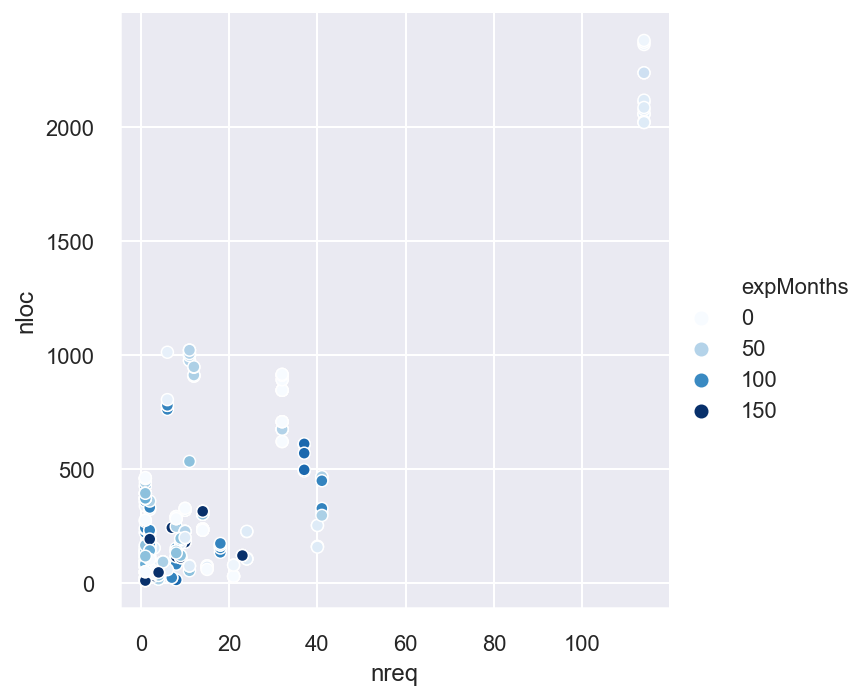

In [421]:
# marker 색상 선택 (search sentence : sns color palette)

sns.relplot(x='nreq', y='nloc', data=df_7, hue='expMonths', palette='Blues')

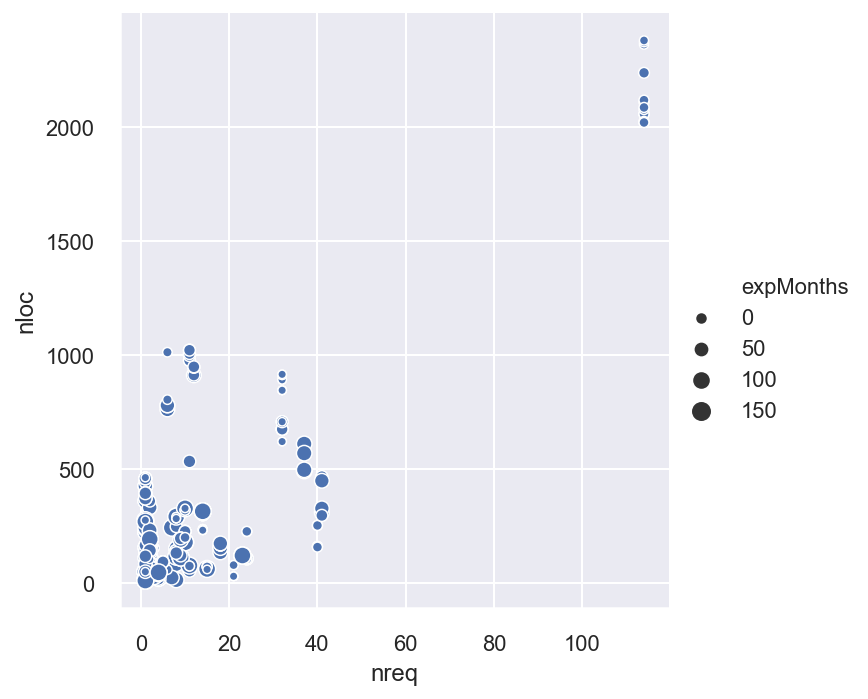

In [422]:
# marker size (search sentence : sns color palette)

sns.relplot(x='nreq', y='nloc', data=df_7, size='expMonths')

In [485]:
df_7['isDefective'] = df_7['isDefective'].replace({'N':-1, 'Y':1})

In [486]:
df_7_metric.columns

Index(['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv',
       'effortToImpl', 'timeToImpl', 'nloc', 'minParaCnt', 'maxParaCnt',
       'totalParaCnt', 'funCnt', 'minCyclo', 'maxCyclo', 'avgCyclo',
       'isDefective'],
      dtype='object')

In [487]:
df_8.columns

AttributeError: 'Index' object has no attribute 'columns'

In [488]:
# 데이터 시각화를 위해 문자열 컬럼 제거 데이터 프레임 (train_4)

df_8 = df_7.drop(columns=['moduleName', 'changer'])

In [492]:
df_8 = df_7_metric

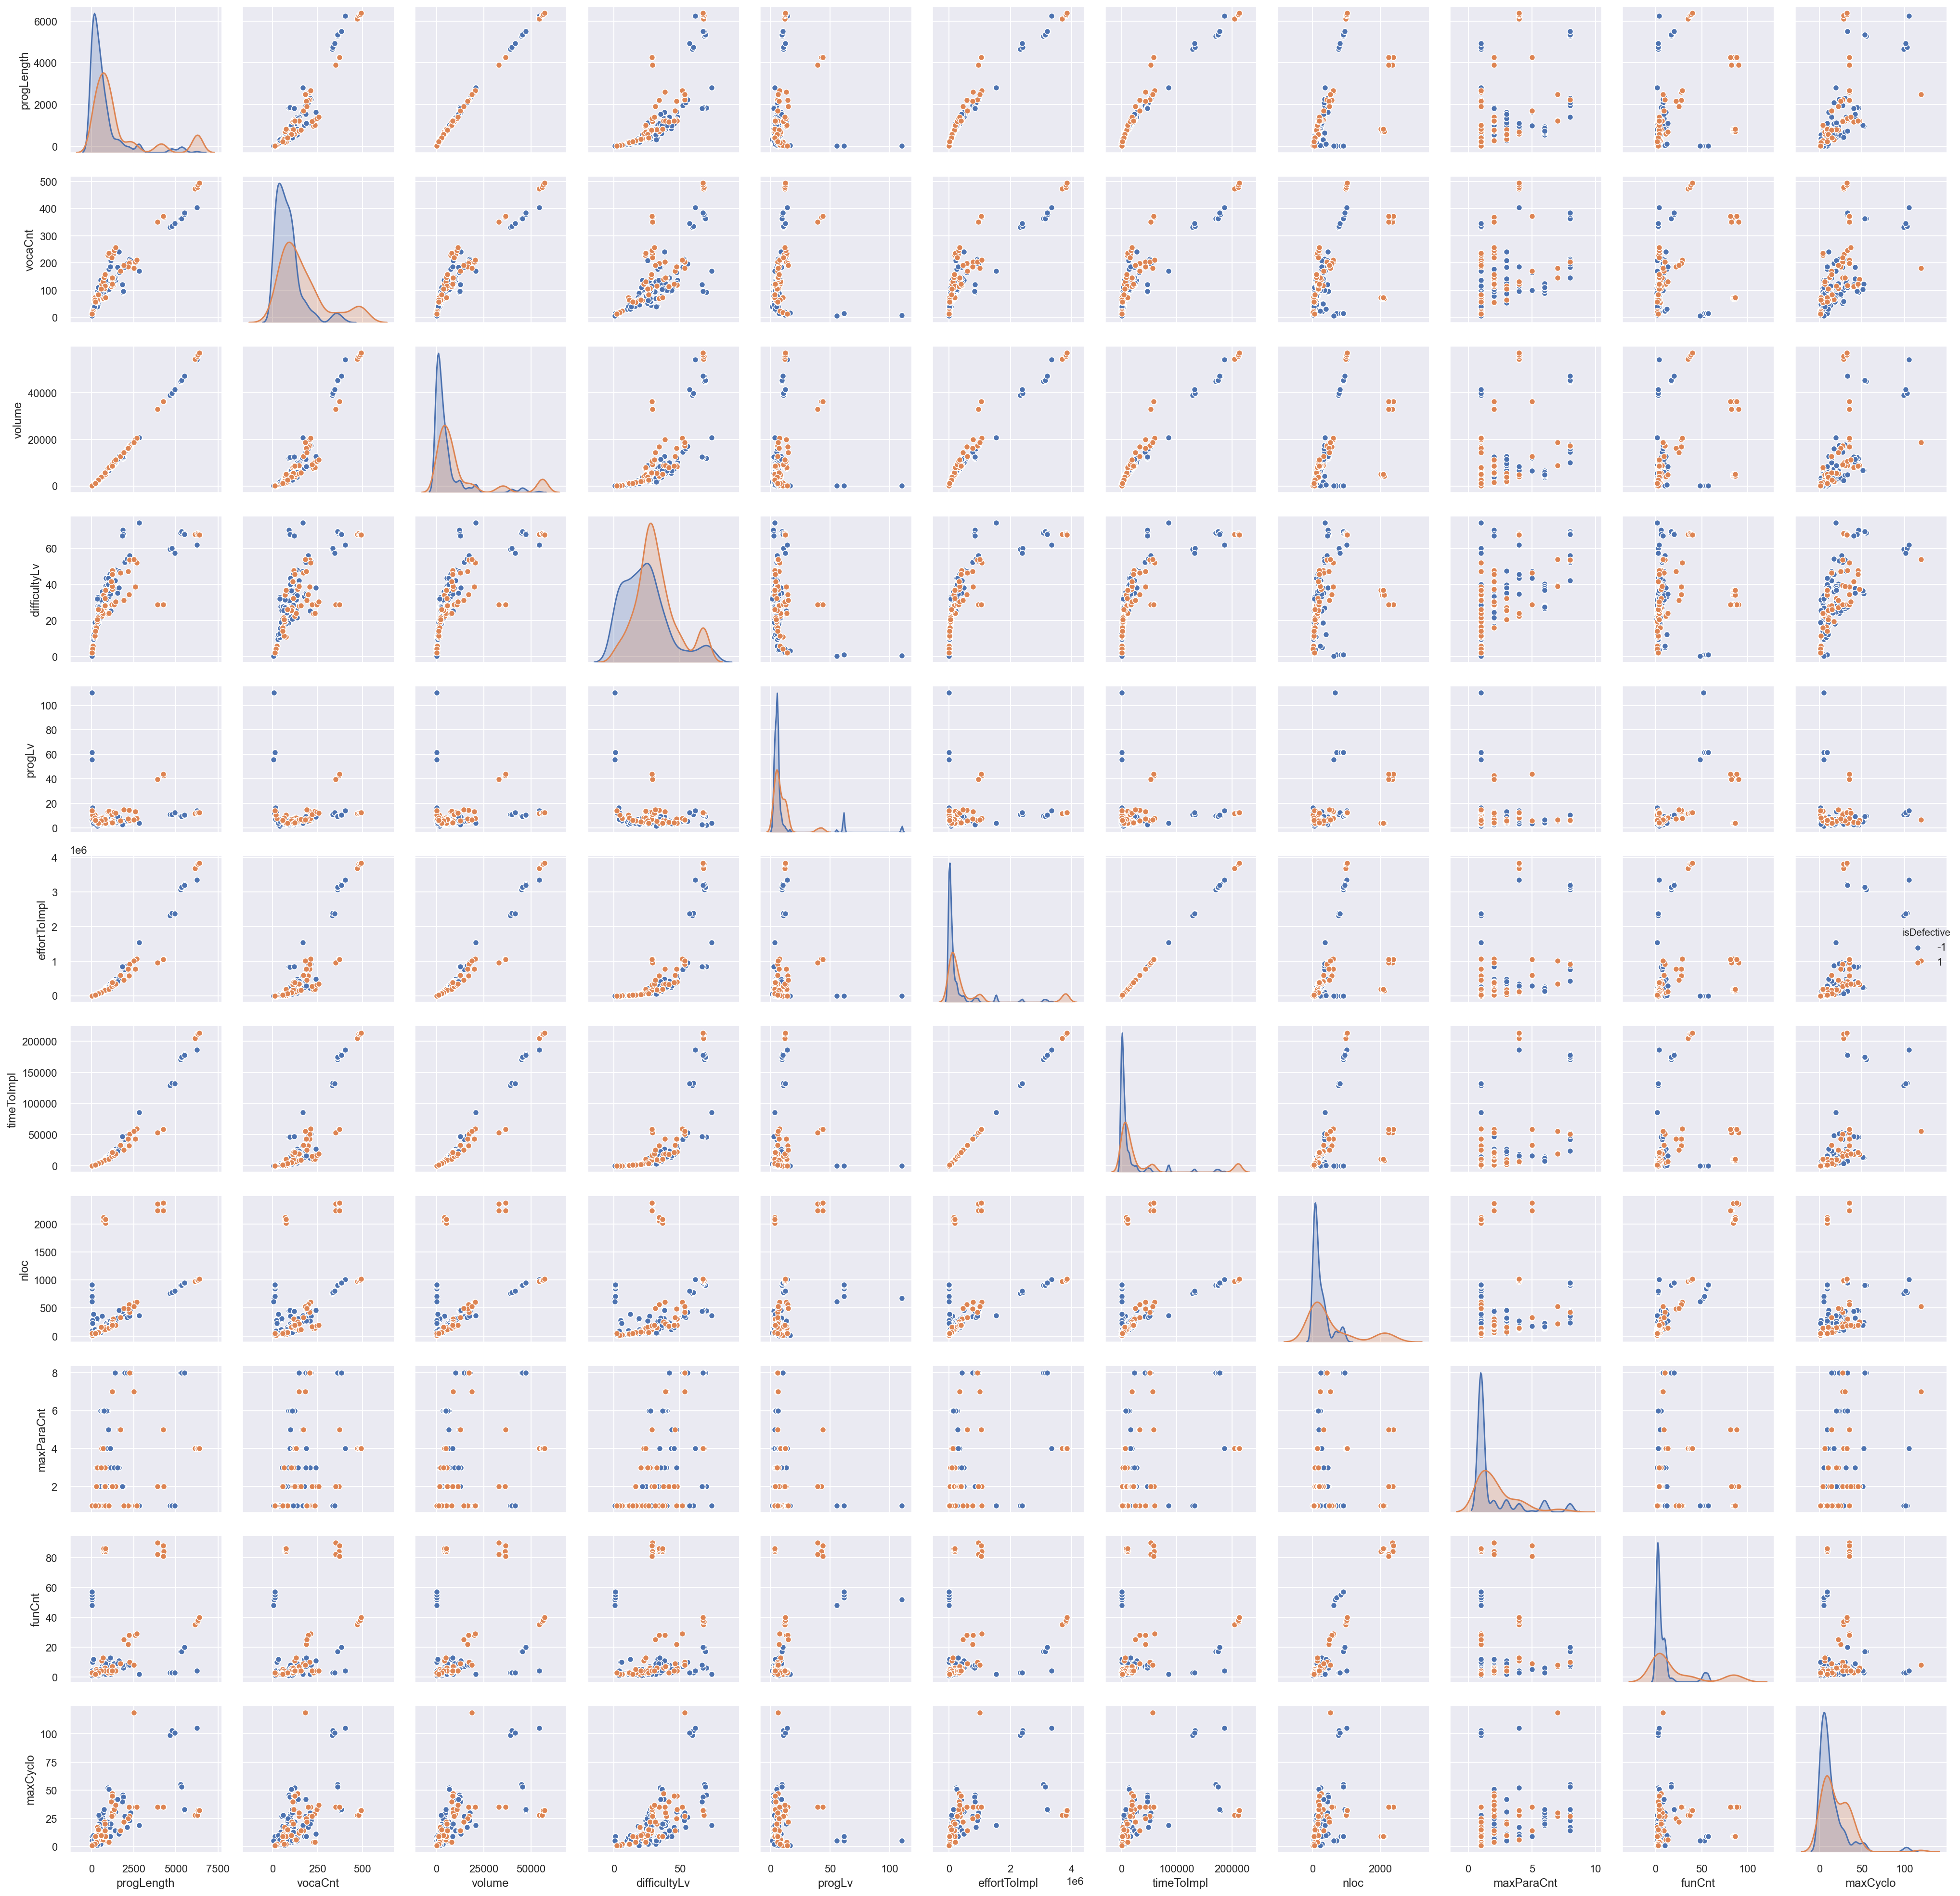

In [493]:
cols_1 = ['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv', 'effortToImpl', 'timeToImpl',\
          'nloc', 'maxParaCnt', 'funCnt', 'maxCyclo', 'isDefective']
cols_2 = ['nloc', 'upTrace', 'downTrace', 'pPORT', 'rPORT', 'revFreq', 'expLvOfDev', 'isDefective']
cols_3 = ['nloc', 'nreq', 'expMonths', 'memberRev', 'isDefective']
sns.pairplot(df_8[cols_1], kind="scatter", height=2.5, hue="isDefective")
plt.tight_layout()
plt.show()

In [494]:
# 결함 상태 (-1: 미결함 / 1: 결함)에 따른 각 컬럼들의 평균 값

df_8.groupby(["isDefective"])[df_8.columns].mean()

,progLength,vocaCnt,volume,difficultyLv,progLv,effortToImpl,timeToImpl,nloc,minParaCnt,maxParaCnt,totalParaCnt,funCnt,minCyclo,maxCyclo,avgCyclo,isDefective
isDefective,,,,,,,,,,,,,,,,
-1,719.722408,86.381271,5238.131141,24.248313,10.601649,254126.343221,14118.130179,230.792642,1.000000,1.949833,7.140468,8.458194,1.461538,13.949833,5.540255,-1
1,1583.255556,170.766667,12734.520785,32.406206,9.656341,618635.641546,34368.646753,581.544444,0.855556,2.233333,11.677778,22.333333,1.666667,19.755556,5.845821,1


In [495]:
corrMatt = df_8
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

              progLength   vocaCnt    volume  difficultyLv    progLv  \
progLength      1.000000  0.942075  0.997254      0.798568 -0.019685   
vocaCnt         0.942075  1.000000  0.940574      0.755264 -0.064310   
volume          0.997254  0.940574  1.000000      0.757823  0.003037   
difficultyLv    0.798568  0.755264  0.757823      1.000000 -0.307005   
progLv         -0.019685 -0.064310  0.003037     -0.307005  1.000000   
effortToImpl    0.967121  0.870155  0.973502      0.745635 -0.010153   
timeToImpl      0.967121  0.870155  0.973502      0.745635 -0.010153   
nloc            0.491500  0.415585  0.491387      0.278698  0.366204   
minParaCnt     -0.003515 -0.147160 -0.002918     -0.025389  0.019242   
maxParaCnt      0.479236  0.506893  0.465436      0.503703 -0.084813   
totalParaCnt    0.694717  0.649394  0.706223      0.461170  0.344796   
funCnt          0.237165  0.176605  0.248172      0.000404  0.595024   
minCyclo       -0.109353 -0.122351 -0.112936     -0.052441 -0.09

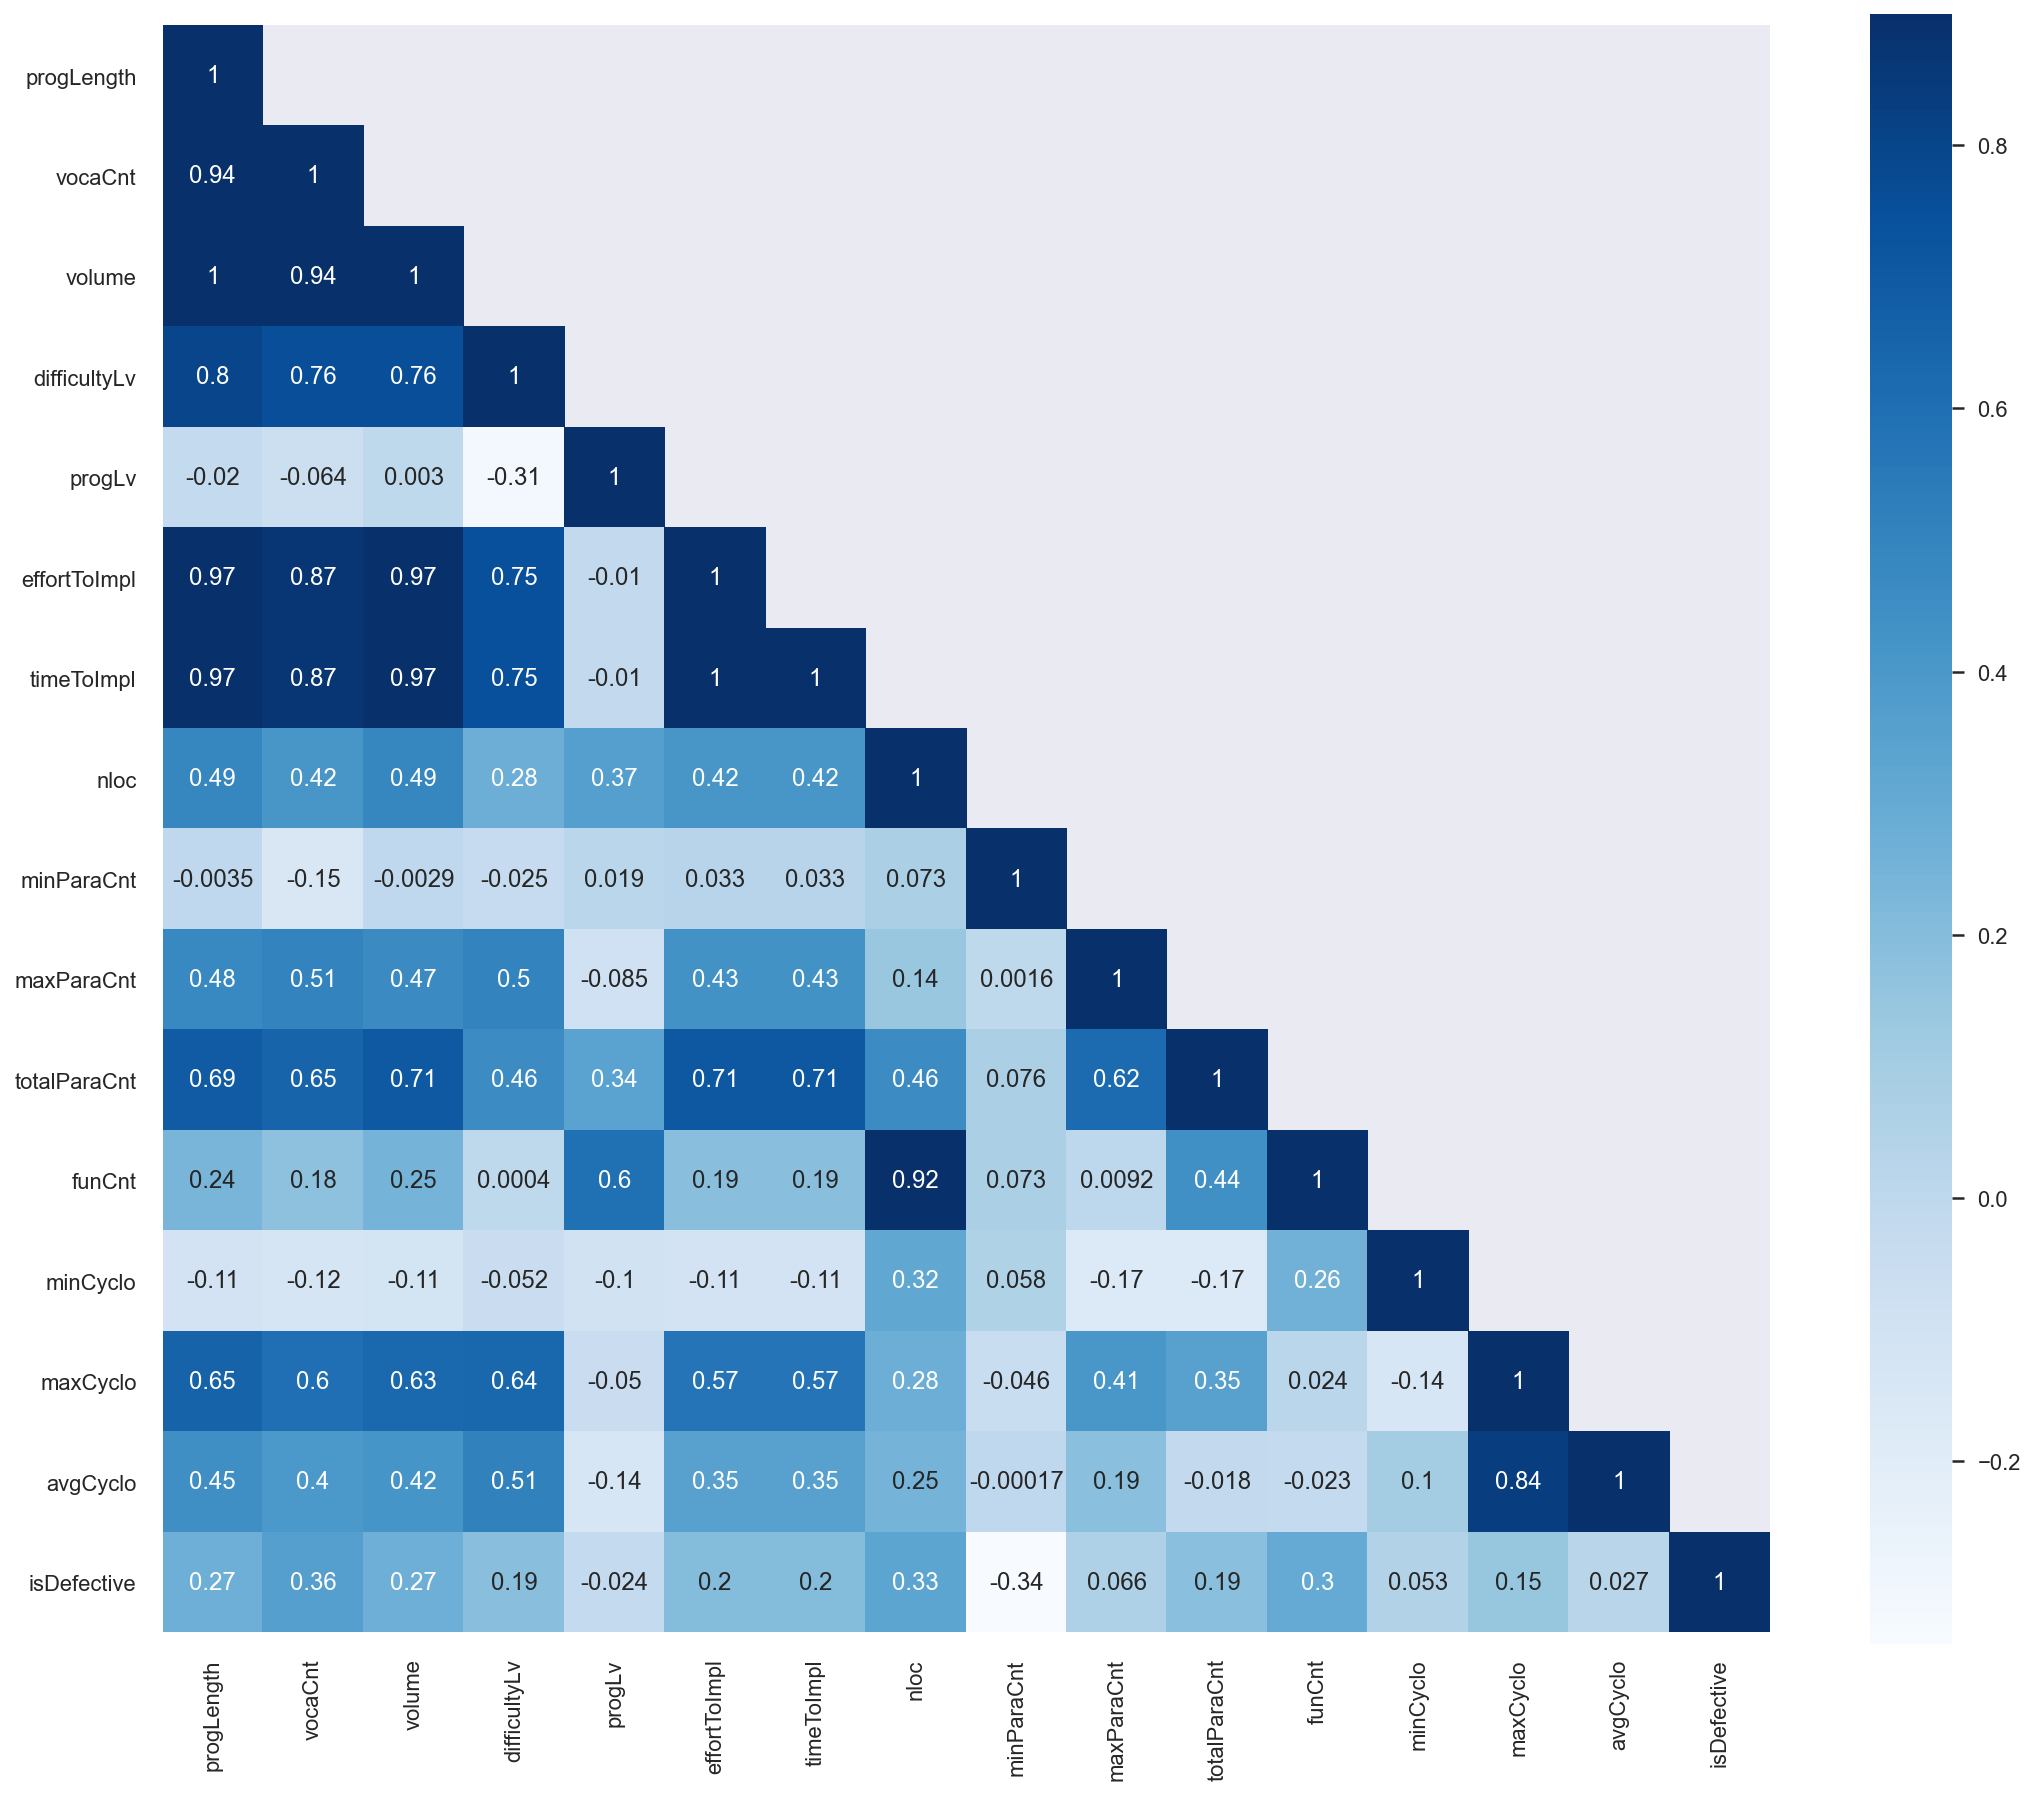

In [496]:
#top_corr_features = corrmat.index[abs(corrmat["isDefective"])>=0]
# plot
plt.figure(figsize=(18,15))
#g = sns.heatmap(corrMatt, mask=mask, annot=True, vmax=.9, square= 10, cmap="RdYlGn")
g = sns.heatmap(corrMatt, mask=mask, annot=True, vmax=.9, square= 10, cmap="Blues")
plt.show()

In [286]:
# feature importance

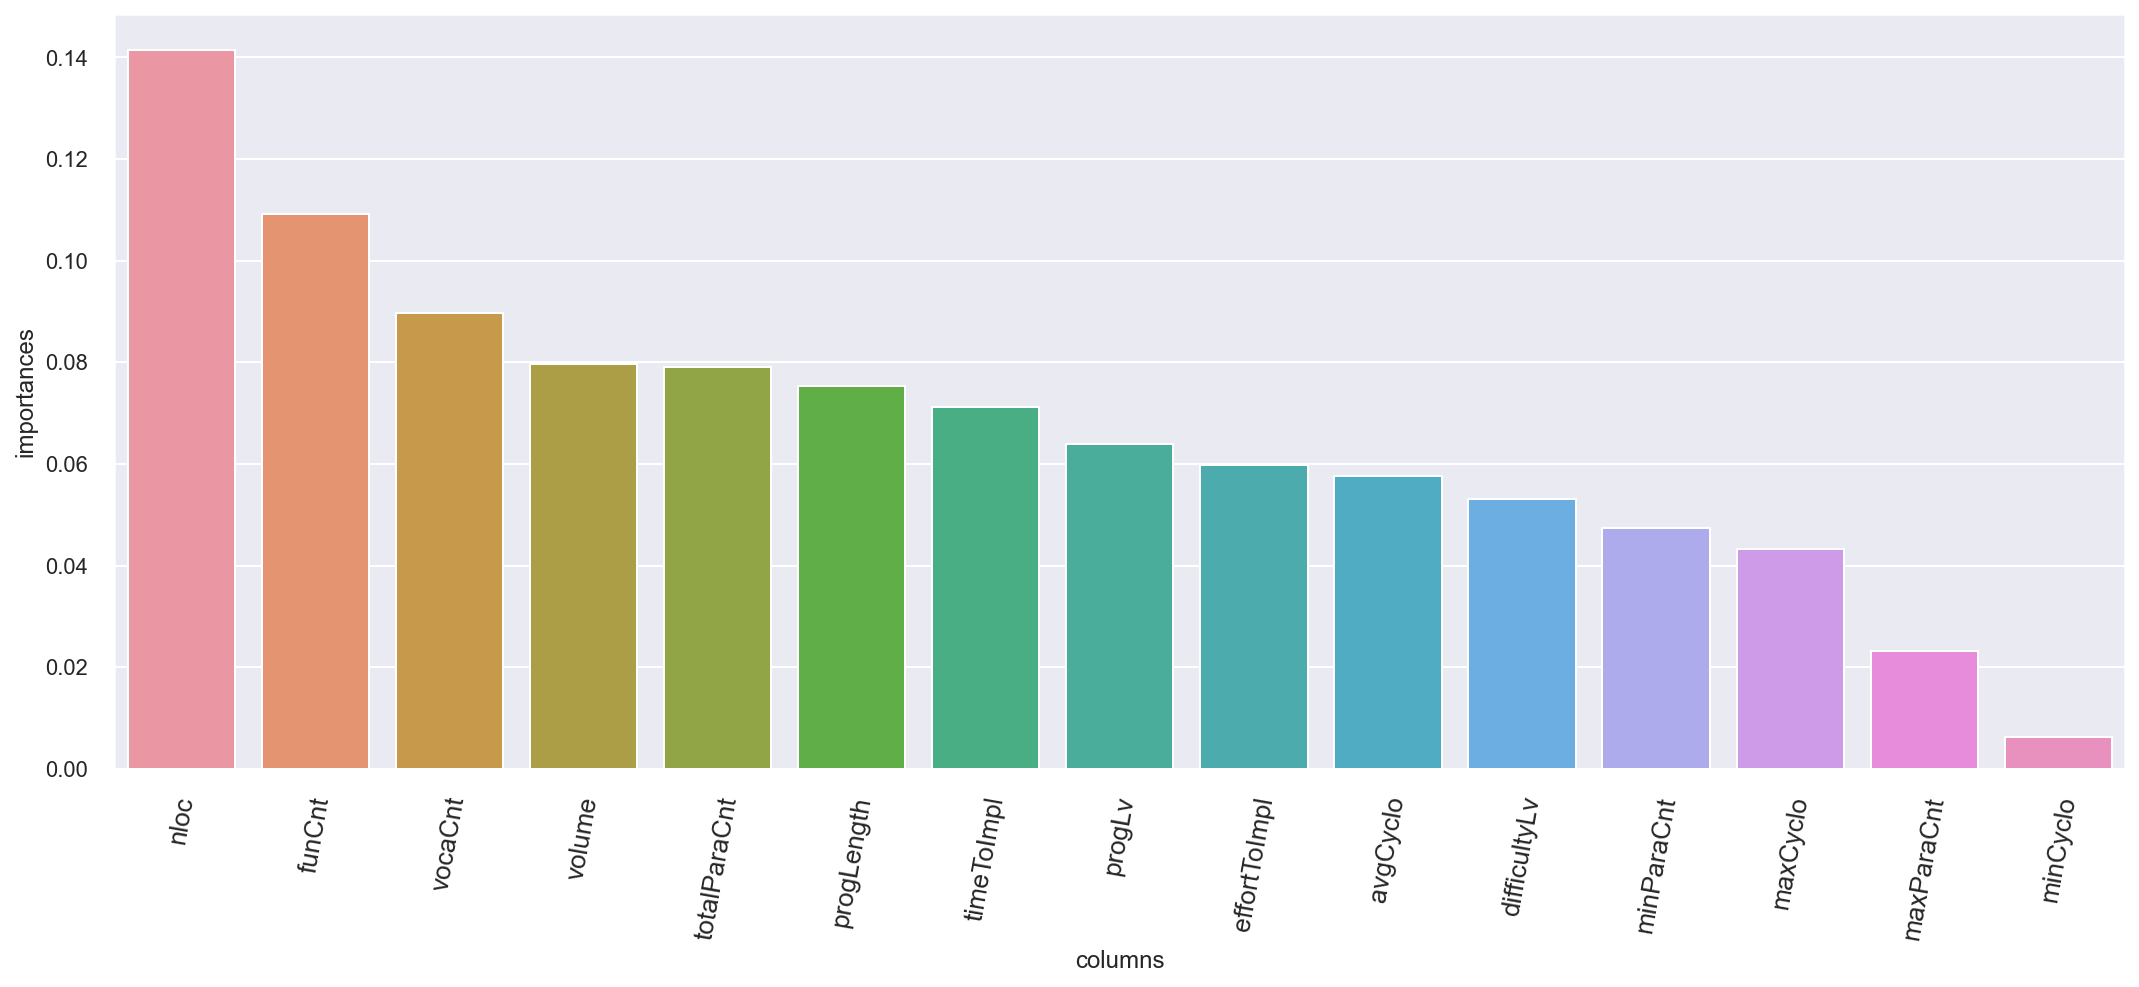

In [497]:
from sklearn.ensemble import RandomForestClassifier

X = df_8.drop(['isDefective'], axis=1)
Y = df_8['isDefective']

# RandomForest
clf = RandomForestClassifier(random_state=42, max_depth=6)
clf.fit(X, Y)
feature_importance = clf.feature_importances_

# plot
df_fi = pd.DataFrame({'columns':X.columns, 'importances':feature_importance})
df_fi = df_fi[df_fi['importances'] > 0] # importance가 0이상인 것만 
df_fi = df_fi.sort_values(by=['importances'], ascending=False)

fig = plt.figure(figsize=(15,7))
ax = sns.barplot(df_fi['columns'], df_fi['importances'])
ax.set_xticklabels(df_fi['columns'], rotation=80, fontsize=13)
plt.tight_layout()
plt.show()

#### 데이터 전처리 2 
- 범주형 -> 숫자형

In [11]:
# 3. 전처리 2 : 범주형 데이터(sex, embarked)-> 숫자형 데이터
# onehot encoding 을 사용

# onehot encoding
onehot_boundary = pd.get_dummies(df_2["affectedBoundary"])
onehot_boundary

,EE System,Product,Software,Vehicle,na
0,1,0,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
552,0,1,0,0,0
553,0,1,0,0,0
554,0,1,0,0,0
555,1,0,0,0,0


In [23]:
df_2["affectedBoundary"].value_counts()

EE System    194
Product      167
Vehicle      153
Software      23
na            20
Name: affectedBoundary, dtype: int64

In [29]:
df_2.groupby(["affectedBoundary"])["isDefective"].mean()

affectedBoundary
EE System    0.134021
Product      0.173653
Software     0.000000
Vehicle      0.202614
na           0.000000
Name: isDefective, dtype: float64

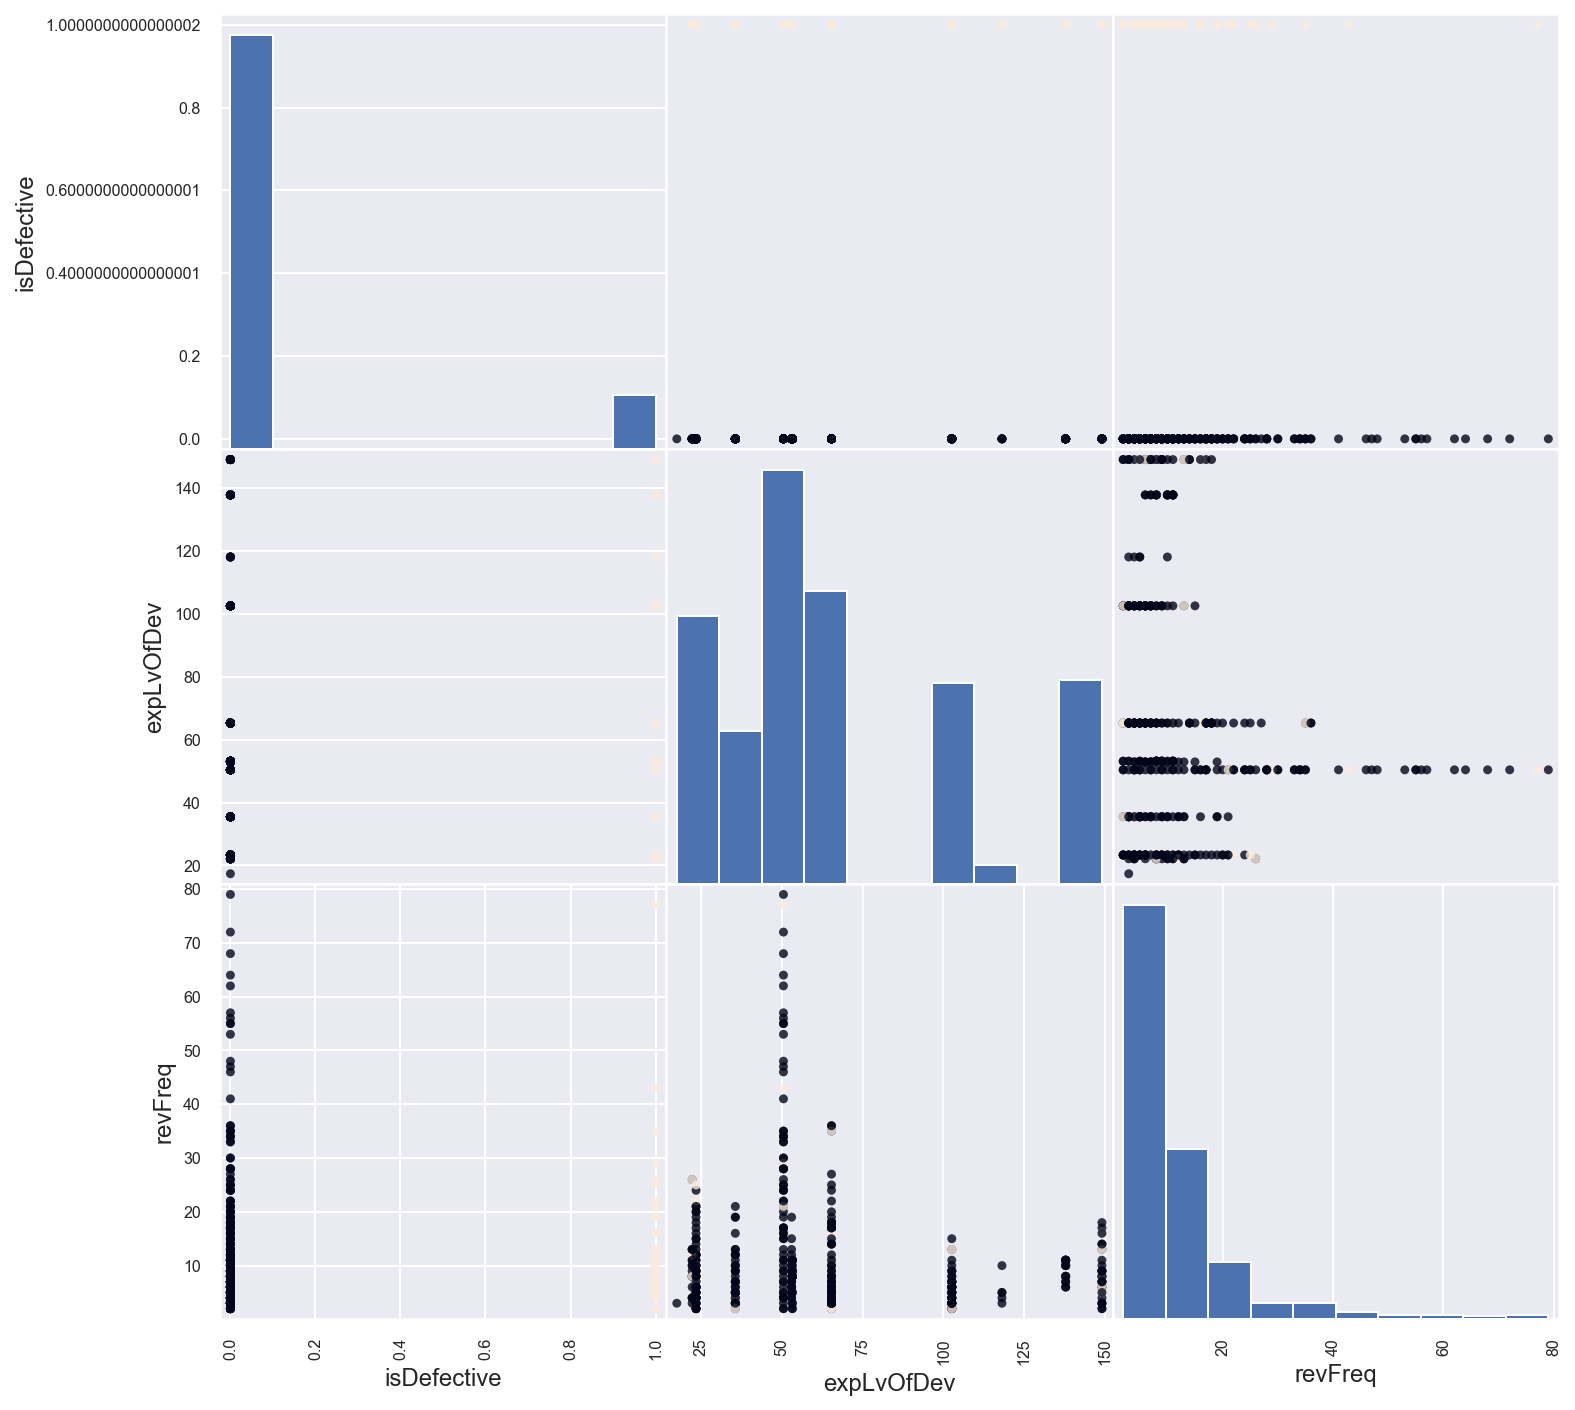

In [94]:
df_target = df_4["isDefective"]
df_cluster = df_4[["isDefective", "expLvOfDev", "revFreq"]]
pd.plotting.scatter_matrix(df_cluster, c=df_target, s=80, alpha=0.8, 
                           figsize=[12,12])
print('')

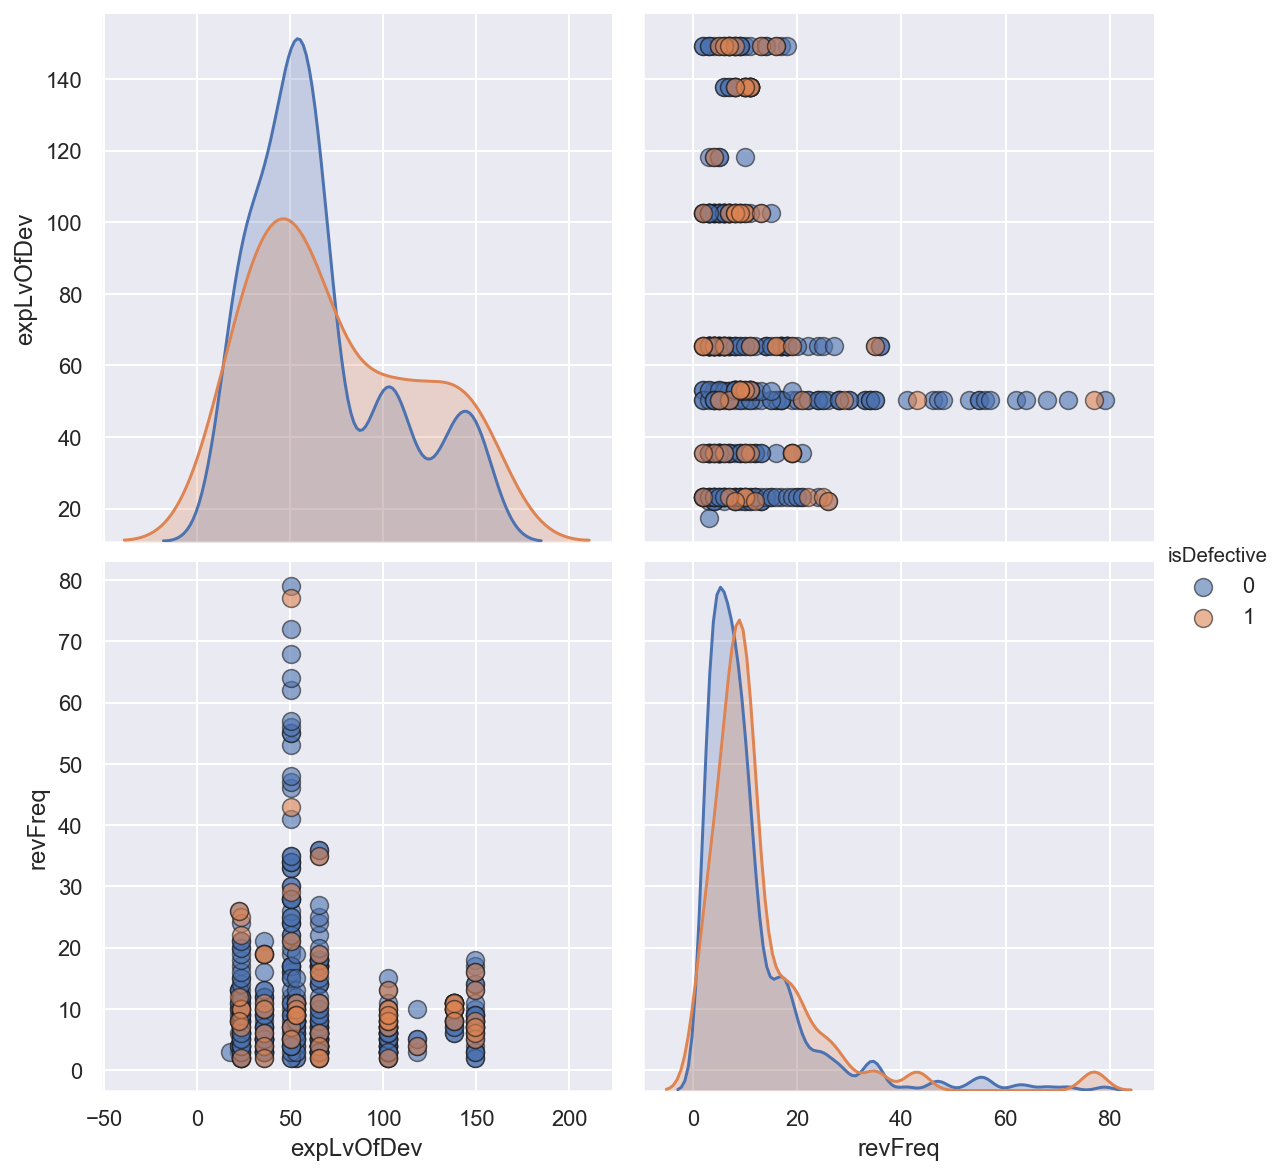

In [95]:
try:
    sns.pairplot(df_cluster, hue="isDefective", plot_kws ={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, size=4)
except Exception as e:
    print(e)
    pass

In [498]:
train_all = df_8.copy()

In [116]:
# outliers 데이터 제거

# trainWithoutOutliers = train_all[np.abs(train['Appliances'] - train_all['Appliances'].mean()) <= (1*train_all['Appliances'].std())]
# print(train_all.shape)
# print(trainWithoutOutliers.shape)

In [499]:
train_all.columns

Index(['progLength', 'vocaCnt', 'volume', 'difficultyLv', 'progLv',
       'effortToImpl', 'timeToImpl', 'nloc', 'minParaCnt', 'maxParaCnt',
       'totalParaCnt', 'funCnt', 'minCyclo', 'maxCyclo', 'avgCyclo',
       'isDefective'],
      dtype='object')

In [500]:
# all 데이터
X = train_all.drop(["isDefective"], axis=1)
Y = train_all["isDefective"]

In [501]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [502]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [503]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(272, 15) (272,) (117, 15) (117,)


### Scaling

In [228]:
# scaler = MinMaxScaler() # 스케일러 인스턴스화
# x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train),
#                       columns=x_train.columns)
# x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test),
#                       columns=x_test.columns)

### Model Test

In [504]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

In [505]:
model = DecisionTreeClassifier(max_depth=20, criterion='entropy', random_state=0).fit(x_train, y_train)
#GNB_mdl = GaussianNB().fit(train_X, train_y)

In [506]:
y_pred = model.predict(x_test)

In [507]:
# Decision Tree Classifier
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.91      0.98      0.94        91
           1       0.89      0.65      0.76        26

    accuracy                           0.91       117
   macro avg       0.90      0.82      0.85       117
weighted avg       0.91      0.91      0.90       117

0.7555555555555555


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

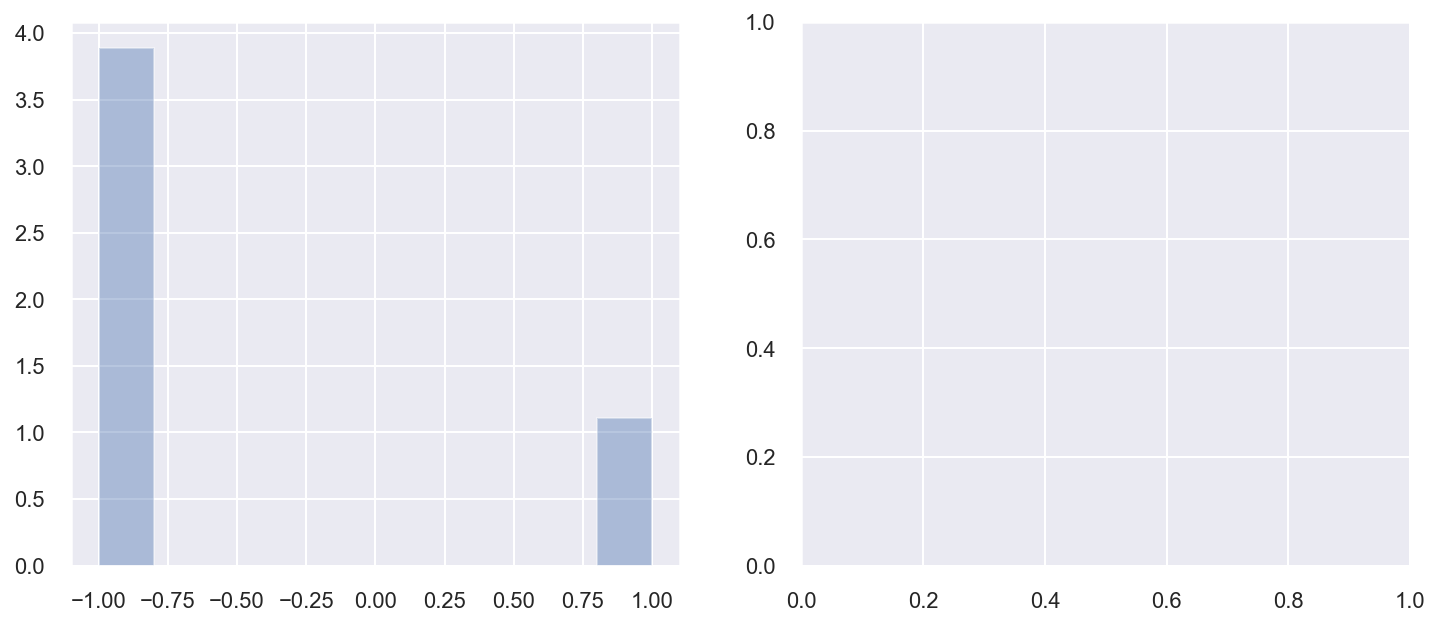

In [508]:
# 학습 데이터 예측 결과 시각화

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sns.distplot(y_test, ax=ax1, bins=10)
ax1.set(title="actual")
sns.distplot(y_pred, ax=ax2, bins=10)
ax2.set(title='prediction')

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

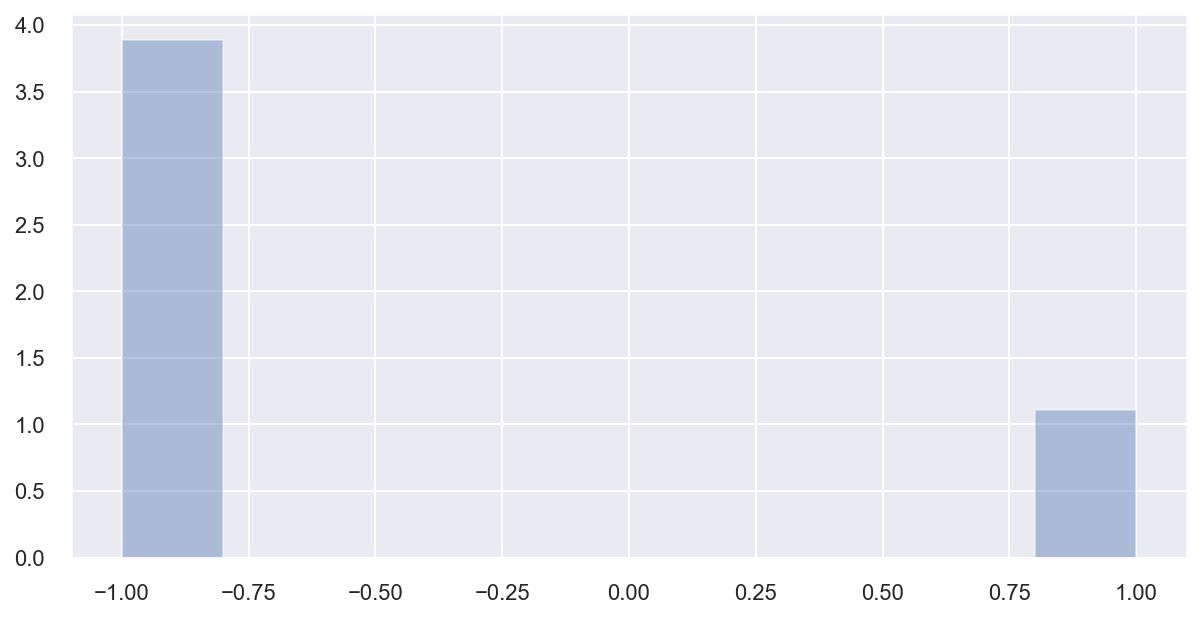

In [446]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(10, 5)
sns.distplot(y_test, ax=ax, bins=10)
sns.distplot(y_pred, ax=ax, bins=10)
fig.legend(labels=['Actual','Prediction'])


In [509]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.metrics import *
from sklearn.model_selection import ParameterGrid

model_parameter_dict = dict() # key : 모델, value : 파라미터 그리드
model_parameter_dict[LR] = ParameterGrid({})
model_parameter_dict[KNN] = ParameterGrid({"n_neighbors":[1, 3, 5, 7],
                                           "weights":["uniform", "distance"],
                                           "leaf_size":[30, 50, 70]})
model_parameter_dict[DTC] = ParameterGrid({"max_depth":[3, 5, 8, 10, 15, 20],
                                           "criterion":["entropy"],
                                            "min_samples_leaf":[1, 3, 5]})
model_parameter_dict[SVC] = ParameterGrid({'kernel':['rbf'],
                                            "C":[2**-4, 2**-2, 2**0, 2** 2],
                                            "gamma":[1, 10 ,100]})
model_parameter_dict[GNB] = ParameterGrid({})
model_parameter_dict[RFC] = ParameterGrid({"n_estimators":[25, 50, 75, 100, 150],
                                           "max_depth":[1, 3, 5],
                                           "min_samples_split":[2, 4]})
# model_parameter_dict[SGDC] = ParameterGrid({"max_iter":[10000, 100000, 1000000],
#                                             "tol":[1e-3, 1e-5, 1e-7]})

In [510]:
best_score = 0

for model in model_parameter_dict.keys():
    for parameter in model_parameter_dict[model]:
        M = model(**parameter).fit(x_train, y_train)
        y_pred = M.predict(x_test)
        score = f1_score(y_test, y_pred)

        print("current score: ", score)
        print("best score: ", best_score)

        if score > best_score:
            best_score = score
            best_model = model
            best_parameter = parameter

current score:  0.27027027027027023
best score:  0
current score:  0.6382978723404256
best score:  0.27027027027027023
current score:  0.6382978723404256
best score:  0.6382978723404256
current score:  0.39999999999999997
best score:  0.6382978723404256
current score:  0.5957446808510638
best score:  0.6382978723404256
current score:  0.5777777777777778
best score:  0.6382978723404256
current score:  0.6666666666666666
best score:  0.6382978723404256
current score:  0.5652173913043479
best score:  0.6666666666666666
current score:  0.7500000000000001
best score:  0.6666666666666666
current score:  0.6382978723404256
best score:  0.7500000000000001
current score:  0.6382978723404256
best score:  0.7500000000000001
current score:  0.39999999999999997
best score:  0.7500000000000001
current score:  0.5957446808510638
best score:  0.7500000000000001
current score:  0.5777777777777778
best score:  0.7500000000000001
current score:  0.6666666666666666
best score:  0.7500000000000001
current 

In [511]:
best_model

sklearn.tree._classes.DecisionTreeClassifier

In [512]:
best_parameter

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}

In [513]:
best_score

0.7555555555555555

In [156]:
model = DTC(**best_parameter).fit(x_train, y_train)

In [158]:
y_pred = model.predict(x_test)

In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.95      1.00      0.97        75
           1       1.00      0.86      0.93        29

    accuracy                           0.96       104
   macro avg       0.97      0.93      0.95       104
weighted avg       0.96      0.96      0.96       104



### Evaluation

### Save Best Model

# Predict new data

## New data information
- Project
- Repository
- 